In [ ]:
# !pip install numpy pandas seaborn matplotlib scikit-learn safetensors
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
# # reben requiring python > 3.9  but < 3.12
# !pip install git+https://git.tu-berlin.de/rsim/reben-training-scripts.git
# !pip install configilm torchsummary

In [244]:
import os
import time
from tempfile import TemporaryDirectory
import itertools
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
import rasterio

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torchvision.models.feature_extraction import create_feature_extractor
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from transformers import AutoImageProcessor, ConvNextV2Model
from tqdm import tqdm
import timm

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

import xgboost as xgb

### Train model on wealth index directly

**direct vit base** seems to give most reasonable looking results.

In [2]:
class VitBaseForRegression(nn.Module):
    def __init__(self, base_model):
        super(VitBaseForRegression, self).__init__()
        self.backbone = base_model
        # Add a regression head
        self.fc = nn.Sequential(
            nn.Linear(base_model.num_features, 1),
            nn.Sigmoid()
        )

        # Freeze the weights of the backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
            
    def forward(self, x):
        features = self.backbone(x)
        outputs = self.fc(features)
        return outputs

model_base = timm.create_model(
    'vit_base_patch16_224.dino',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model_base)
model_transforms = timm.data.create_transform(**data_config, is_training=False)

# Create regression model
model_reg = VitBaseForRegression(model_base)

# Use GPU training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_reg.to(device);

criterion = nn.MSELoss()
optimizer = optim.SGD(model_reg.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [3]:
# transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),               # Randomly flip horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),                 # Randomly flip vertically with a probability of 0.5
    transforms.RandomRotation(degrees=30),                # Randomly rotate within the range [-30, 30] degrees
    transforms.RandomAffine(degrees=0, shear=10),         # Apply shearing with a range of [-10, 10] degrees
    # transforms.ToTensor(),                                # Convert the image to a tensor
    model_transforms
])

val_transform = model_transforms
test_transform = model_transforms

data_transforms = {
    'train': train_transform,
    'val': val_transform,
    'test': test_transform
}

In [4]:
# Load target information
target_path = 'data'
df_target_raw = pd.read_csv(os.path.join(target_path,'y.csv'))\
    .rename(columns={'Wealth_Index':'target'})
df_target_raw['filename'] = df_target_raw['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_target_raw.drop(columns='DHSCLUST', inplace=True)
df_target_raw = df_target_raw.astype({'target':'float32'})

In [5]:
# Custom Dataset class
class RegressionDataset(Dataset):
    def __init__(self, image_folder, targets_df, transform=None):
        self.image_folder = image_folder
        self.targets_df = targets_df
        self.transform = transform
        self.image_files = targets_df['filename'].tolist()
        self.targets = targets_df['target']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

In [6]:
# Load the full dataset
df_target = df_target_raw.copy()
image_folder = 'data/daysat/2022/'

# Perform train test split
ind_training, ind_test = train_test_split(df_target.index, test_size=0.2, random_state=42)
ind_train, ind_val = train_test_split(ind_training, test_size=0.2, random_state=42)

# MinMaxScale to target
scaler = MinMaxScaler()
df_target.loc[ind_train,'target'] = scaler.fit_transform(df_target.loc[ind_train,['target']])
df_target.loc[ind_val,'target'] = scaler.transform(df_target.loc[ind_val,['target']])
df_target.loc[ind_test,'target'] = scaler.transform(df_target.loc[ind_test,['target']])

# Create datasets
train_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target.loc[ind_train,:].reset_index(drop=True),transform=data_transforms['train'])
val_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target.loc[ind_val,:].reset_index(drop=True),transform=data_transforms['val'])
test_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target.loc[ind_test,:].reset_index(drop=True),transform=data_transforms['test'])

# Determine the sizes for the different datasets
total_size, train_val_size, train_size, val_size, test_size = len(df_target), len(ind_train) + len(ind_val), len(ind_train), len(ind_val), len(ind_test)
dataset_sizes = {'train':train_size, 'val':val_size, 'test': test_size}

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4),
    'test': DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
}

In [7]:
# Training code
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,verbose=0,plot_curves=True):
    since = time.time()

    df = pd.DataFrame({'train':np.zeros([num_epochs]), 'val':np.zeros([num_epochs])})
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = 1e10

        for epoch in range(num_epochs):
            if verbose == 1:
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs).squeeze()
                        loss = criterion(outputs, labels.squeeze())

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]

                if verbose == 1:
                    print(f'{phase} Loss: {epoch_loss:.4f}')
                df.loc[epoch,phase] = epoch_loss

                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            if verbose == 1:
                print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        if plot_curves:
            df.plot()
        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, df

Training complete in 0m 22s


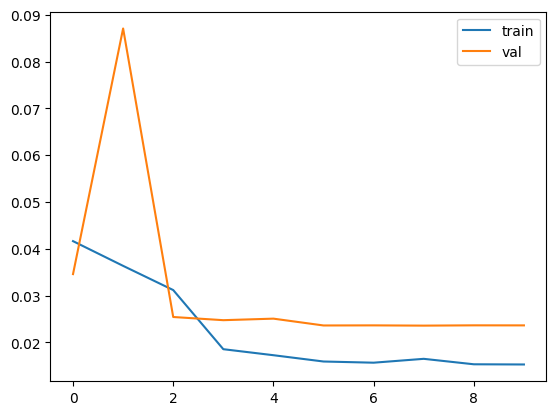

In [8]:
# Train model
model_reg, df = train_model(model_reg, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=10,verbose=0,plot_curves=True)

In [9]:
# Initialize lists to store the outputs and labels
all_outputs = []
all_labels = []

model_reg.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)  # Ensure labels are also on the correct device
        outputs = model_reg(inputs)

        # Collect outputs and labels
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all collected outputs and labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

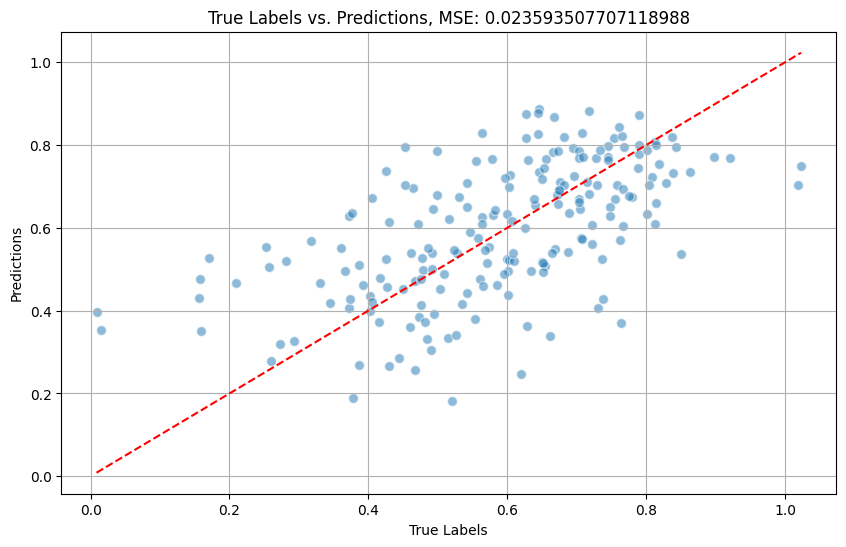

In [10]:
import matplotlib.pyplot as plt

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
plt.show()

### Train model on nightlight (vit base)

As before, direct vit base seems to be the best approach.

In [33]:
class VitBaseForRegression2(nn.Module):
    def __init__(self, base_model):
        super(VitBaseForRegression2, self).__init__()
        self.backbone = base_model
        # Add a regression head
        self.fc = nn.Sequential(
            # nn.BatchNorm1d(base_model.num_features),  # Batch normalization
            nn.Linear(base_model.num_features, 512),  # First layer
            nn.BatchNorm1d(512),                      # Batch normalization
            nn.ReLU(),                                # Activation function
            nn.Dropout(0.3),                          # Dropout for regularization
            
            nn.Linear(512, 256),                      # Second layer
            nn.BatchNorm1d(256),                      # Batch normalization
            nn.ReLU(),                                # Activation function
            nn.Dropout(0.3),                          # Dropout for regularization
            
            nn.Linear(256, 128),                      # Third layer
            nn.BatchNorm1d(128),                      # Batch normalization
            nn.ReLU(),                                # Activation function
            nn.Dropout(0.3),                          # Dropout for regularization
            
            nn.Linear(128, 1),                        # Output layer
        )
        
        # Freeze the weights of the backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
            
    def forward(self, x):
        features = self.backbone(x)
        outputs = self.fc(features)
        return outputs

model_base = timm.create_model(
    'vit_base_patch16_224.dino',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model_base)
model_transforms = timm.data.create_transform(**data_config, is_training=False)

# Create regression model
model_reg = VitBaseForRegression2(model_base)

# Use GPU training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_reg.to(device);

criterion = nn.MSELoss()
optimizer = optim.SGD(model_reg.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

In [34]:
# transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),               # Randomly flip horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),                 # Randomly flip vertically with a probability of 0.5
    transforms.RandomRotation(degrees=30),                # Randomly rotate within the range [-30, 30] degrees
    transforms.RandomAffine(degrees=0, shear=10),         # Apply shearing with a range of [-10, 10] degrees
    # transforms.ToTensor(),                                # Convert the image to a tensor
    model_transforms
])

val_transform = model_transforms
test_transform = model_transforms

data_transforms = {
    'train': train_transform,
    'val': val_transform,
    'test': test_transform
}

In [35]:
# Load target information, log transform then min max scale
target_path = 'data'
df_target_raw = pd.read_csv(os.path.join(target_path,'X.csv'))\
    .rename(columns={'avg_rad_min':'target'})
df_target_raw['filename'] = df_target_raw['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_target_raw = df_target_raw[['filename','target']]
df_target_raw = df_target_raw.astype({'target':'float32'})

In [36]:
# Custom Dataset class
class RegressionDataset(Dataset):
    def __init__(self, image_folder, targets_df, transform=None):
        self.image_folder = image_folder
        self.targets_df = targets_df
        self.transform = transform
        self.image_files = targets_df['filename'].tolist()
        self.targets = targets_df['target']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target


In [37]:
# Load the full dataset
df_target = df_target_raw.copy()
image_folder = 'data/daysat/2022/'

# Perform train test split
ind_training, ind_test = train_test_split(df_target.index, test_size=0.2, random_state=42)
ind_train, ind_val = train_test_split(ind_training, test_size=0.2, random_state=42)

# # MinMaxScale + log to target
# scaler = MinMaxScaler()
# df_target.loc[ind_train,'target'] = scaler.fit_transform(np.log(df_target.loc[ind_train,['target']]))
# df_target.loc[ind_val,'target'] = scaler.transform(np.log(df_target.loc[ind_val,['target']]))
# df_target.loc[ind_test,'target'] = scaler.transform(np.log(df_target.loc[ind_test,['target']]))

# # log transform target
# df_target.loc[ind_train,'target'] = np.log(df_target.loc[ind_train,['target']])
# df_target.loc[ind_val,'target'] = np.log(df_target.loc[ind_val,['target']])
# df_target.loc[ind_test,'target'] = np.log(df_target.loc[ind_test,['target']])

# Create datasets
train_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target.loc[ind_train,:].reset_index(drop=True),transform=data_transforms['train'])
val_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target.loc[ind_val,:].reset_index(drop=True),transform=data_transforms['val'])
test_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target.loc[ind_test,:].reset_index(drop=True),transform=data_transforms['test'])

# Determine the sizes for the different datasets
total_size, train_val_size, train_size, val_size, test_size = len(df_target), len(ind_train) + len(ind_val), len(ind_train), len(ind_val), len(ind_test)
dataset_sizes = {'train':train_size, 'val':val_size, 'test': test_size}

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=16,drop_last=True),
    'val': DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=16,drop_last=True),
    'test': DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=16,drop_last=True)
}

In [38]:
# Training code
def train_model(model, criterion, optimizer, scheduler,
                num_epochs=25,verbose=0,plot_curves=True):
    since = time.time()
    df = pd.DataFrame({'train':np.zeros([num_epochs]), 'val':np.zeros([num_epochs])})
    
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = 1e10

        for epoch in range(num_epochs):
            if verbose == 1 and epoch%20==0:
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs).squeeze()
                        loss = criterion(outputs, labels.squeeze())

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]

                if verbose == 1 and epoch%20==0:
                    print(f'{phase} Loss: {epoch_loss:.4f}')
                df.loc[epoch,phase] = epoch_loss

                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            if verbose == 1 and epoch%20==0:
                print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        if plot_curves:
            df.plot()
        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, df

Epoch 0/19
----------
train Loss: 23.3270
val Loss: 27.9059

Training complete in 0m 51s


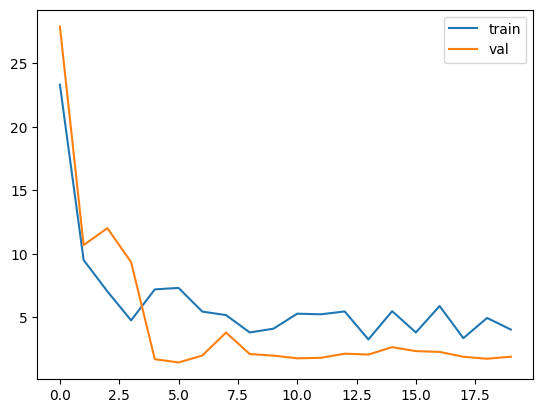

In [39]:
# Train model
model_reg, df = train_model(model_reg, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=20,verbose=1,plot_curves=True)

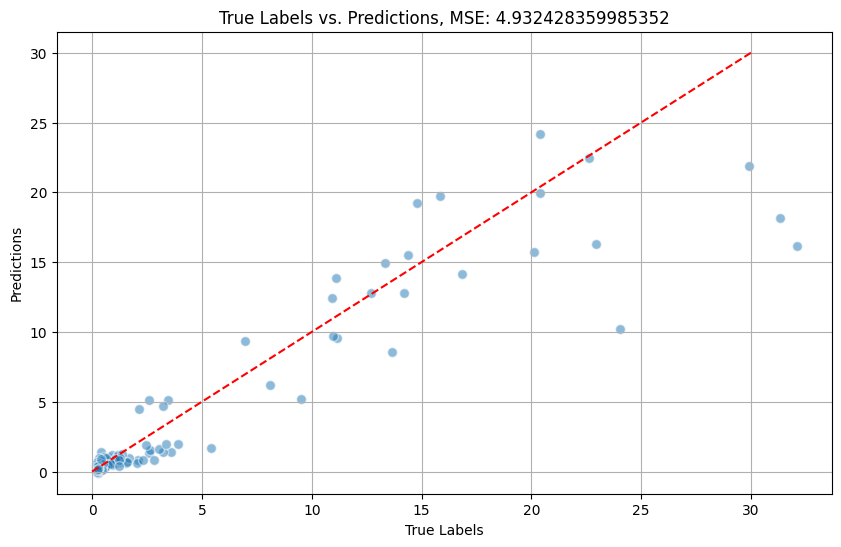

In [40]:
# Initialize lists to store the outputs and labels
all_outputs = []
all_labels = []

model_reg.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)  # Ensure labels are also on the correct device
        outputs = model_reg(inputs)

        # Collect outputs and labels
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all collected outputs and labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([0,30], [0,30], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
# plt.ylim([0,1])

### Train model on nightlight (vit base) - full dataset

In [2]:
class VitBaseForRegression2(nn.Module):
    def __init__(self, base_model):
        super(VitBaseForRegression2, self).__init__()
        self.backbone = base_model
        # Add a regression head
        self.fc = nn.Sequential(
            nn.BatchNorm1d(base_model.num_features),  # Batch normalization
            nn.Linear(base_model.num_features, 512),  # First layer
            nn.BatchNorm1d(512),                      # Batch normalization
            nn.ReLU(),                                # Activation function
            nn.Dropout(0.3),                          # Dropout for regularization
            
            # nn.Linear(512, 256),                      # Second layer
            # nn.BatchNorm1d(256),                      # Batch normalization
            # nn.ReLU(),                                # Activation function
            # nn.Dropout(0.3),                          # Dropout for regularization
            
            # nn.Linear(256, 128),                      # Third layer
            # nn.BatchNorm1d(128),                      # Batch normalization
            # nn.ReLU(),                                # Activation function
            # nn.Dropout(0.3),                          # Dropout for regularization
            
            # nn.Linear(128, 64),                      # Third layer
            # nn.BatchNorm1d(64),                      # Batch normalization
            # nn.ReLU(),                                # Activation function
            # nn.Dropout(0.3),                          # Dropout for regularization

            # nn.Linear(64, 32),                      # Third layer
            # nn.BatchNorm1d(32),                      # Batch normalization
            # nn.ReLU(),                                # Activation function
            # nn.Dropout(0.3),                          # Dropout for regularization

            nn.Linear(512, 1),                        # Output layer
            # nn.Linear(256, 1),                        # Output layer
            # nn.Linear(128, 1),                        # Output layer
            # nn.Linear(64, 1),                        # Output layer
            # nn.Linear(32, 1),                        # Output layer

            # nn.BatchNorm1d(base_model.num_features),  # Batch normalization'
            # nn.Dropout(0.5),                          # Dropout for regularization
            # nn.Linear(base_model.num_features, 1)                        # Output layer
        )
        
        # Freeze the weights of the backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
            
    def forward(self, x):
        features = self.backbone(x)
        outputs = self.fc(features)
        return outputs

model_base = timm.create_model(
    'vit_base_patch16_224.dino',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model_base)
model_transforms = timm.data.create_transform(**data_config, is_training=False)

# Create regression model
model_reg = VitBaseForRegression2(model_base)

# Use GPU training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_reg.to(device);

criterion = nn.MSELoss()
optimizer = optim.SGD(model_reg.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [3]:
# transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),               # Randomly flip horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),                 # Randomly flip vertically with a probability of 0.5
    transforms.RandomRotation(degrees=30),                # Randomly rotate within the range [-30, 30] degrees
    transforms.RandomAffine(degrees=0, shear=10),         # Apply shearing with a range of [-10, 10] degrees
    # transforms.ToTensor(),                                # Convert the image to a tensor
    model_transforms
])

val_transform = model_transforms
test_transform = model_transforms

data_transforms = {
    'train': train_transform,
    'val': val_transform,
    'test': test_transform
}

In [4]:
# Load target information, log transform then min max scale
target_path = 'data'
df_target_raw = pd.read_csv(os.path.join(target_path,'X_2022_grid.csv'))\
    .rename(columns={'avg_rad_min':'target'}).drop(columns=['Unnamed: 0'])
df_target_raw['filename'] = pd.Series(df_target_raw.index).map(lambda x: 'map_'+str(x)+'.tif')
df_target_raw = df_target_raw[['filename','target']]
df_target_raw = df_target_raw.astype({'target':'float32'})

In [5]:
# Custom Dataset class
class RegressionDataset(Dataset):
    def __init__(self, image_folder, targets_df, transform=None):
        self.image_folder = image_folder
        self.targets_df = targets_df
        self.transform = transform
        self.image_files = targets_df['filename'].tolist()
        self.targets = targets_df['target']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target


In [6]:
# Load the full dataset
df_target = df_target_raw.copy()
image_folder = 'data/daysat/2022_grid/'

# Perform train test split
ind_training, ind_test = train_test_split(df_target.index, test_size=0.1, random_state=42)
ind_train, ind_val = train_test_split(ind_training, test_size=0.1, random_state=42)

# Create datasets
train_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target.loc[ind_train,:].reset_index(drop=True),transform=data_transforms['train'])
val_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target.loc[ind_val,:].reset_index(drop=True),transform=data_transforms['val'])
test_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target.loc[ind_test,:].reset_index(drop=True),transform=data_transforms['test'])

# Determine the sizes for the different datasets
total_size, train_val_size, train_size, val_size, test_size = len(df_target), len(ind_train) + len(ind_val), len(ind_train), len(ind_val), len(ind_test)
dataset_sizes = {'train':train_size, 'val':val_size, 'test': test_size}

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=16,drop_last=False),
    'val': DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=16,drop_last=False),
    'test': DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=16,drop_last=False)
}

In [7]:
from tqdm import tqdm
import time
import torch
import pandas as pd
import numpy as np
import os
from tempfile import TemporaryDirectory

# Training code
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes,
                num_epochs=25, verbose=0, plot_curves=True):
    since = time.time()
    df = pd.DataFrame({'train': np.zeros([num_epochs]), 'val': np.zeros([num_epochs])})

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = 1e10

        for epoch in range(num_epochs):
            if verbose == 1: # and epoch % 1 == 0:
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()  # Set model to evaluate mode

                running_loss = 0.0

                # Iterate over data with progress bar
                with tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Epoch {epoch + 1}/{num_epochs}', unit='batch') as pbar:
                    for inputs, labels in pbar:
                        inputs = inputs.to(device)
                        labels = labels.to(device)

                        # zero the parameter gradients
                        optimizer.zero_grad()

                        # forward
                        # track history if only in train
                        with torch.set_grad_enabled(phase == 'train'):
                            outputs = model(inputs).squeeze()
                            loss = criterion(outputs, labels.squeeze())

                            # backward + optimize only if in training phase
                            if phase == 'train':
                                loss.backward()
                                optimizer.step()

                        # statistics
                        running_loss += loss.item() * inputs.size(0)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                if verbose == 1: # and epoch%20==0:
                    print(f'{phase} Loss: {epoch_loss:.4f}')
                df.loc[epoch, phase] = epoch_loss

                # Update progress bar with the loss
                pbar.set_postfix({'Loss': f'{epoch_loss:.4f}'})

                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            if verbose == 1: # and epoch % 1 == 0:
                print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        if plot_curves:
            df.plot()

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, df


In [8]:
# Train model
model_reg, df = train_model(model_reg, criterion, optimizer, exp_lr_scheduler,dataloaders, dataset_sizes,
                       num_epochs=30,verbose=1,plot_curves=False)

Epoch 0/29
----------


Train Epoch 1/30: 100%|██████████| 588/588 [01:09<00:00,  8.49batch/s]


train Loss: 0.5173


Val Epoch 1/30: 100%|██████████| 66/66 [00:08<00:00,  8.19batch/s]


val Loss: 0.5095

Epoch 1/29
----------


Train Epoch 2/30: 100%|██████████| 588/588 [01:10<00:00,  8.34batch/s]


train Loss: 0.4062


Val Epoch 2/30: 100%|██████████| 66/66 [00:08<00:00,  8.05batch/s]


val Loss: 0.3885

Epoch 2/29
----------


Train Epoch 3/30: 100%|██████████| 588/588 [01:09<00:00,  8.42batch/s]


train Loss: 0.3819


Val Epoch 3/30: 100%|██████████| 66/66 [00:08<00:00,  8.10batch/s]


val Loss: 0.3653

Epoch 3/29
----------


Train Epoch 4/30: 100%|██████████| 588/588 [01:09<00:00,  8.42batch/s]


train Loss: 0.3605


Val Epoch 4/30: 100%|██████████| 66/66 [00:08<00:00,  8.13batch/s]


val Loss: 0.3032

Epoch 4/29
----------


Train Epoch 5/30: 100%|██████████| 588/588 [01:10<00:00,  8.34batch/s]


train Loss: 0.3355


Val Epoch 5/30: 100%|██████████| 66/66 [00:08<00:00,  8.04batch/s]


val Loss: 0.3787

Epoch 5/29
----------


Train Epoch 6/30: 100%|██████████| 588/588 [01:10<00:00,  8.36batch/s]


train Loss: 0.3194


Val Epoch 6/30: 100%|██████████| 66/66 [00:08<00:00,  8.07batch/s]


val Loss: 0.4069

Epoch 6/29
----------


Train Epoch 7/30: 100%|██████████| 588/588 [01:10<00:00,  8.35batch/s]


train Loss: 0.3308


Val Epoch 7/30: 100%|██████████| 66/66 [00:08<00:00,  8.13batch/s]


val Loss: 0.3478

Epoch 7/29
----------


Train Epoch 8/30: 100%|██████████| 588/588 [01:09<00:00,  8.42batch/s]


train Loss: 0.3173


Val Epoch 8/30: 100%|██████████| 66/66 [00:08<00:00,  8.04batch/s]


val Loss: 0.2963

Epoch 8/29
----------


Train Epoch 9/30: 100%|██████████| 588/588 [01:09<00:00,  8.48batch/s]


train Loss: 0.3067


Val Epoch 9/30: 100%|██████████| 66/66 [00:07<00:00,  8.31batch/s]


val Loss: 0.2998

Epoch 9/29
----------


Train Epoch 10/30: 100%|██████████| 588/588 [01:08<00:00,  8.55batch/s]


train Loss: 0.3105


Val Epoch 10/30: 100%|██████████| 66/66 [00:08<00:00,  8.22batch/s]


val Loss: 0.3156

Epoch 10/29
----------


Train Epoch 11/30: 100%|██████████| 588/588 [01:08<00:00,  8.53batch/s]


train Loss: 0.2829


Val Epoch 11/30: 100%|██████████| 66/66 [00:07<00:00,  8.29batch/s]


val Loss: 0.2709

Epoch 11/29
----------


Train Epoch 12/30: 100%|██████████| 588/588 [01:09<00:00,  8.51batch/s]


train Loss: 0.2736


Val Epoch 12/30: 100%|██████████| 66/66 [00:08<00:00,  8.07batch/s]


val Loss: 0.2725

Epoch 12/29
----------


Train Epoch 13/30: 100%|██████████| 588/588 [01:09<00:00,  8.42batch/s]


train Loss: 0.2668


Val Epoch 13/30: 100%|██████████| 66/66 [00:08<00:00,  8.24batch/s]


val Loss: 0.2646

Epoch 13/29
----------


Train Epoch 14/30: 100%|██████████| 588/588 [01:10<00:00,  8.36batch/s]


train Loss: 0.2744


Val Epoch 14/30: 100%|██████████| 66/66 [00:08<00:00,  8.12batch/s]


val Loss: 0.3281

Epoch 14/29
----------


Train Epoch 15/30: 100%|██████████| 588/588 [01:10<00:00,  8.37batch/s]


train Loss: 0.2616


Val Epoch 15/30: 100%|██████████| 66/66 [00:08<00:00,  8.01batch/s]


val Loss: 0.2863

Epoch 15/29
----------


Train Epoch 16/30: 100%|██████████| 588/588 [01:10<00:00,  8.37batch/s]


train Loss: 0.2574


Val Epoch 16/30: 100%|██████████| 66/66 [00:08<00:00,  8.14batch/s]


val Loss: 0.2877

Epoch 16/29
----------


Train Epoch 17/30: 100%|██████████| 588/588 [01:10<00:00,  8.37batch/s]


train Loss: 0.2734


Val Epoch 17/30: 100%|██████████| 66/66 [00:08<00:00,  8.13batch/s]


val Loss: 0.2628

Epoch 17/29
----------


Train Epoch 18/30: 100%|██████████| 588/588 [01:10<00:00,  8.34batch/s]


train Loss: 0.2610


Val Epoch 18/30: 100%|██████████| 66/66 [00:08<00:00,  8.19batch/s]


val Loss: 0.2561

Epoch 18/29
----------


Train Epoch 19/30: 100%|██████████| 588/588 [01:09<00:00,  8.41batch/s]


train Loss: 0.2537


Val Epoch 19/30: 100%|██████████| 66/66 [00:08<00:00,  8.13batch/s]


val Loss: 0.2714

Epoch 19/29
----------


Train Epoch 20/30: 100%|██████████| 588/588 [01:10<00:00,  8.38batch/s]


train Loss: 0.2539


Val Epoch 20/30: 100%|██████████| 66/66 [00:08<00:00,  8.12batch/s]


val Loss: 0.2861

Epoch 20/29
----------


Train Epoch 21/30: 100%|██████████| 588/588 [01:10<00:00,  8.38batch/s]


train Loss: 0.2336


Val Epoch 21/30: 100%|██████████| 66/66 [00:08<00:00,  8.17batch/s]


val Loss: 0.2694

Epoch 21/29
----------


Train Epoch 22/30: 100%|██████████| 588/588 [01:10<00:00,  8.39batch/s]


train Loss: 0.2335


Val Epoch 22/30: 100%|██████████| 66/66 [00:08<00:00,  8.11batch/s]


val Loss: 0.2652

Epoch 22/29
----------


Train Epoch 23/30: 100%|██████████| 588/588 [01:10<00:00,  8.35batch/s]


train Loss: 0.2333


Val Epoch 23/30: 100%|██████████| 66/66 [00:08<00:00,  8.16batch/s]


val Loss: 0.2901

Epoch 23/29
----------


Train Epoch 24/30: 100%|██████████| 588/588 [01:09<00:00,  8.43batch/s]


train Loss: 0.2374


Val Epoch 24/30: 100%|██████████| 66/66 [00:08<00:00,  8.20batch/s]


val Loss: 0.2541

Epoch 24/29
----------


Train Epoch 25/30: 100%|██████████| 588/588 [01:09<00:00,  8.51batch/s]


train Loss: 0.2242


Val Epoch 25/30: 100%|██████████| 66/66 [00:07<00:00,  8.29batch/s]


val Loss: 0.2548

Epoch 25/29
----------


Train Epoch 26/30: 100%|██████████| 588/588 [01:08<00:00,  8.53batch/s]


train Loss: 0.2325


Val Epoch 26/30: 100%|██████████| 66/66 [00:07<00:00,  8.29batch/s]


val Loss: 0.2504

Epoch 26/29
----------


Train Epoch 27/30: 100%|██████████| 588/588 [01:08<00:00,  8.53batch/s]


train Loss: 0.2254


Val Epoch 27/30: 100%|██████████| 66/66 [00:07<00:00,  8.32batch/s]


val Loss: 0.2540

Epoch 27/29
----------


Train Epoch 28/30: 100%|██████████| 588/588 [01:08<00:00,  8.53batch/s]


train Loss: 0.2299


Val Epoch 28/30: 100%|██████████| 66/66 [00:08<00:00,  8.23batch/s]


val Loss: 0.2513

Epoch 28/29
----------


Train Epoch 29/30: 100%|██████████| 588/588 [01:08<00:00,  8.53batch/s]


train Loss: 0.2315


Val Epoch 29/30: 100%|██████████| 66/66 [00:07<00:00,  8.36batch/s]


val Loss: 0.2518

Epoch 29/29
----------


Train Epoch 30/30: 100%|██████████| 588/588 [01:08<00:00,  8.53batch/s]


train Loss: 0.2330


Val Epoch 30/30: 100%|██████████| 66/66 [00:08<00:00,  8.22batch/s]


val Loss: 0.2653

Training complete in 38m 58s


<Axes: >

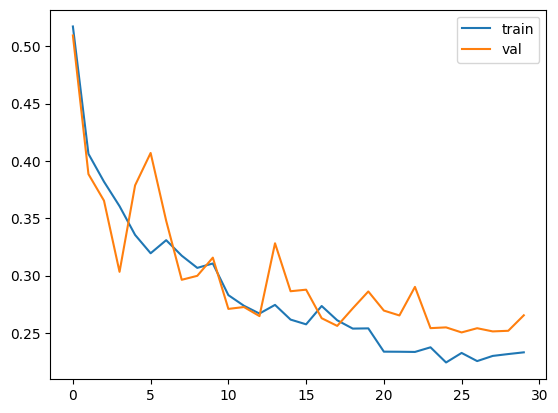

In [9]:
# lr=0.001, 10 steps, 30 epochs, gamma = 0.5
df.plot()

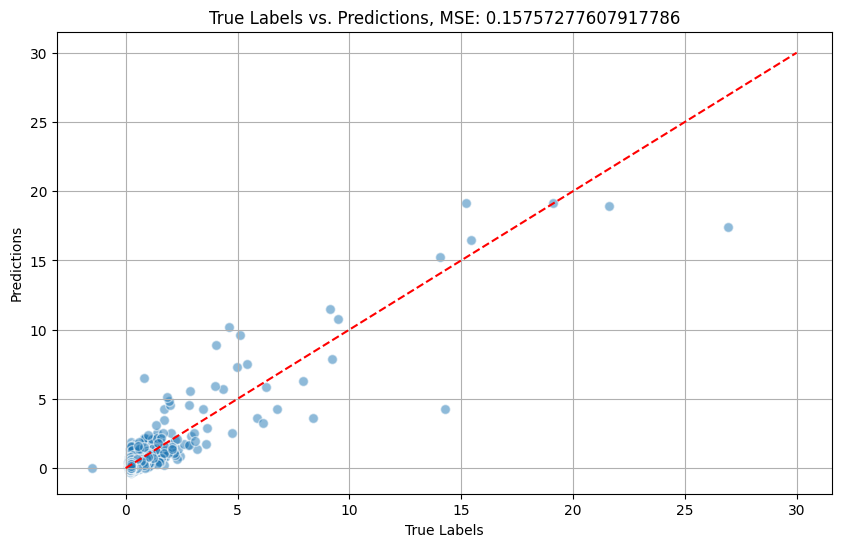

In [10]:
# Initialize lists to store the outputs and labels
all_outputs = []
all_labels = []

model_reg.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)  # Ensure labels are also on the correct device
        outputs = model_reg(inputs)

        # Collect outputs and labels
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all collected outputs and labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([0,30], [0,30], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
# plt.ylim([0,1])

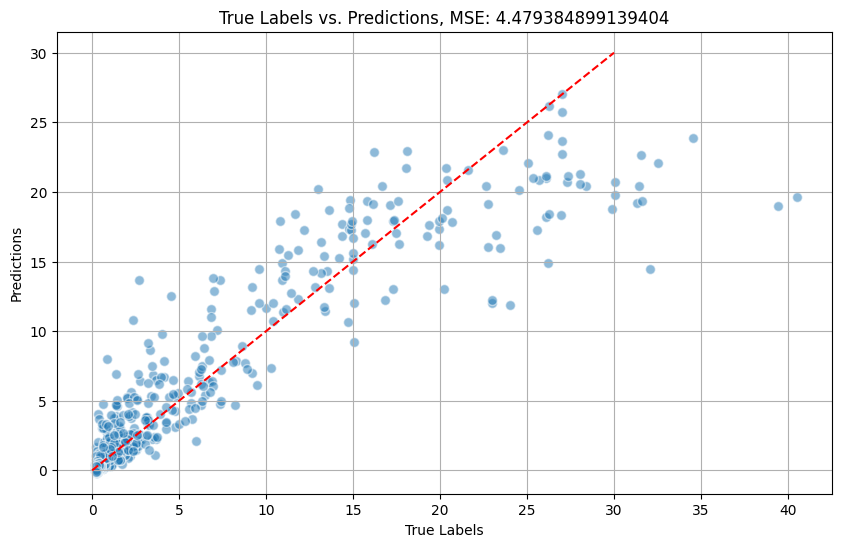

In [14]:
# get features for dhs clusters
dhs_path = 'data'
df_dhs = pd.read_csv(os.path.join(dhs_path,'X.csv'))\
    .rename(columns={'avg_rad_min':'target'})
df_dhs['filename'] = df_dhs['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_dhs = df_dhs[['filename','target']]
df_dhs = df_dhs.astype({'target':'float32'})

# Load the full dataset
image_folder = 'data/daysat/2022/'

# Create datasets
test_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_dhs,transform=data_transforms['test'])

# Create DataLoader instances
dataloaders = {
    'test': DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=16,drop_last=False)
}

# Initialize lists to store the outputs and labels
all_outputs = []
all_labels = []

model_reg.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)  # Ensure labels are also on the correct device
        outputs = model_reg(inputs)

        # Collect outputs and labels
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all collected outputs and labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([0,30], [0,30], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
# plt.ylim([0,1])

In [15]:
# Initialize lists to store the outputs and labels
return_nodes = {
    "fc.1": "lin_out"
}
model_reg_extractor = create_feature_extractor(model_reg, return_nodes=return_nodes)
model_reg_extractor.eval()  # Set the model to evaluation mode

all_outputs = []
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        outputs = model_reg_extractor(inputs)
        all_outputs.append(outputs['lin_out'].squeeze().cpu().numpy())
test_img_feat = np.concatenate(all_outputs, axis=0)

with open(os.path.join(dhs_path,'img_feat_dhs_2022_fc1.pkl'),'wb') as f:
    pickle.dump(test_img_feat,f)

In [16]:
# Initialize lists to store the outputs and labels
return_nodes = {
    "fc.2": "lin_out"
}
model_reg_extractor = create_feature_extractor(model_reg, return_nodes=return_nodes)
model_reg_extractor.eval()  # Set the model to evaluation mode

all_outputs = []
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        outputs = model_reg_extractor(inputs)
        all_outputs.append(outputs['lin_out'].squeeze().cpu().numpy())
test_img_feat = np.concatenate(all_outputs, axis=0)

with open(os.path.join(dhs_path,'img_feat_dhs_2022_fc2.pkl'),'wb') as f:
    pickle.dump(test_img_feat,f)

In [17]:
# Initialize lists to store the outputs and labels
return_nodes = {
    "fc.3": "lin_out"
}
model_reg_extractor = create_feature_extractor(model_reg, return_nodes=return_nodes)
model_reg_extractor.eval()  # Set the model to evaluation mode

all_outputs = []
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        outputs = model_reg_extractor(inputs)
        all_outputs.append(outputs['lin_out'].squeeze().cpu().numpy())
test_img_feat = np.concatenate(all_outputs, axis=0)

with open(os.path.join(dhs_path,'img_feat_dhs_2022_fc3.pkl'),'wb') as f:
    pickle.dump(test_img_feat,f)

In [18]:
# Initialize lists to store the outputs and labels
return_nodes = {
    "fc.4": "lin_out"
}
model_reg_extractor = create_feature_extractor(model_reg, return_nodes=return_nodes)
model_reg_extractor.eval()  # Set the model to evaluation mode

all_outputs = []
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        outputs = model_reg_extractor(inputs)
        all_outputs.append(outputs['lin_out'].squeeze().cpu().numpy())
test_img_feat = np.concatenate(all_outputs, axis=0)

with open(os.path.join(dhs_path,'img_feat_dhs_2022_fc4.pkl'),'wb') as f:
    pickle.dump(test_img_feat,f)

### Train model on nightlight (XGBoost)

For exploration. not useful. cannot extract features this way and not sure the following is worth the time https://medium.com/@joachimiak.krzysztof/generating-features-with-gradient-boosted-decision-trees-e8c9fafcb9b7

In [329]:
# Load data
target_path = 'data'
df_target_raw = pd.read_csv(os.path.join(target_path,'y.csv'))
df_target_raw['filename'] = df_target_raw['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_target_raw.drop(columns=['DHSCLUST','Wealth_Index'], inplace=True)
df_target_raw = pd.concat([df_target_raw,pd.read_csv(os.path.join(target_path,'X.csv'))['avg_rad_min']],axis=1)
df_target_raw.rename(columns={'avg_rad_min':'target'},inplace=True)
df_target_raw = df_target_raw.astype({'target':'float32'})

# Perform train test split
ind_training, ind_test = train_test_split(df_target_raw.index, test_size=0.2, random_state=42)
ind_train, ind_val = train_test_split(ind_training, test_size=0.2, random_state=42)

# Load the full dataset
df_target = df_target_raw.copy()
image_folder = 'data/daysat/2022/'

# MinMaxScale to target
scaler = MinMaxScaler()
# df_target.loc[ind_train,'target'] = scaler.fit_transform(df_target.loc[ind_train,['target']])
# df_target.loc[ind_val,'target'] = scaler.transform(df_target.loc[ind_val,['target']])
# df_target.loc[ind_test,'target'] = scaler.transform(df_target.loc[ind_test,['target']])

df_target.loc[ind_train.union(ind_val),'target'] = scaler.fit_transform(df_target.loc[ind_train.union(ind_val),['target']])
df_target.loc[ind_test,'target'] = scaler.transform(df_target.loc[ind_test,['target']])

In [330]:
# Custom Dataset class
class RegressionDataset(Dataset):
    def __init__(self, image_folder, targets_df, transform=None):
        self.image_folder = image_folder
        self.targets_df = targets_df
        self.transform = transform
        self.image_files = targets_df['filename'].tolist()
        self.targets = targets_df['target']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

model_base = timm.create_model(
    'vit_base_patch16_224.dino',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model_base)
model_transforms = timm.data.create_transform(**data_config, is_training=False)

# Create datasets
train_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target.loc[ind_train,:].reset_index(drop=True),transform=model_transforms)
val_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target.loc[ind_val,:].reset_index(drop=True),transform=model_transforms)
test_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target.loc[ind_test,:].reset_index(drop=True),transform=model_transforms)

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=False, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)
}

# Extract image features
model_base.eval()  # Set the model to evaluation mode

train_img_feat=[]
with torch.no_grad():
    for inputs, labels in dataloaders['train']:
        inputs = inputs
        outputs = model_base(inputs)
        train_img_feat.append(outputs.cpu().numpy())
train_img_feat_raw = np.concatenate(train_img_feat, axis=0)

val_img_feat=[]
with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs
        outputs = model_base(inputs)
        val_img_feat.append(outputs.cpu().numpy())
val_img_feat_raw = np.concatenate(val_img_feat, axis=0)

test_img_feat=[]
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs
        outputs = model_base(inputs)
        test_img_feat.append(outputs.cpu().numpy())
test_img_feat_raw = np.concatenate(test_img_feat, axis=0)

In [331]:
# Create copies of original
train_img_feat = train_img_feat_raw.copy()
val_img_feat = val_img_feat_raw.copy()
test_img_feat = test_img_feat_raw.copy()

# Scale before PCA
scaler_img = StandardScaler()
scaler_img.fit(np.vstack([train_img_feat,val_img_feat]))
train_img_feat = scaler_img.transform(train_img_feat)
val_img_feat = scaler_img.transform(val_img_feat)
test_img_feat = scaler_img.transform(test_img_feat)

# Perform PCA
pca_img = PCA(n_components=50)
pca_img.fit(np.vstack([train_img_feat,val_img_feat]))
print(np.sum(pca_img.explained_variance_ratio_))
train_img_feat = pca_img.transform(train_img_feat)
val_img_feat = pca_img.transform(val_img_feat)
test_img_feat = pca_img.transform(test_img_feat)

0.670763


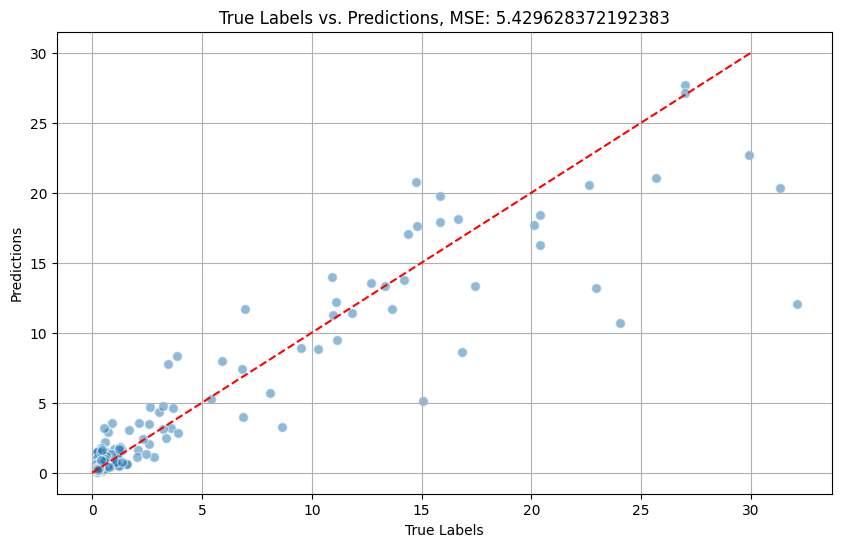

In [332]:
# Get targets
y_train = df_target.loc[ind_train,'target']
y_val = df_target.loc[ind_val,'target']
y_test = df_target.loc[ind_test,'target']

# Get image features
X_train_img = pd.DataFrame(train_img_feat,
                           columns=[f'img_{i}' for i in range(train_img_feat.shape[1])],
                           index=y_train.index)
X_val_img = pd.DataFrame(val_img_feat,
                           columns=[f'img_{i}' for i in range(val_img_feat.shape[1])],
                           index=y_val.index)
X_test_img = pd.DataFrame(test_img_feat,
                           columns=[f'img_{i}' for i in range(test_img_feat.shape[1])],
                           index=y_test.index)

# After quick grid search below
params = {
    'learning_rate': 0.01, 'n_estimators': 2000, 'max_depth': 5,
    'min_child_weight': 1,    'gamma': 0,
    'subsample': 1, 'colsample_bytree': 0.8,
    'reg_lambda': 1, 'reg_alpha': 0, 'objective': 'reg:squarederror',
    'random_state': 42, 'device':'cuda', 'tree_method':'hist',    # 'enable_categorical':True
}

model_xgb_base = xgb.XGBRegressor(**params)
# model_xgb_base.fit(X_trainval_img[feature_names], y_trainval)
model_xgb_base.fit(pd.concat([X_train_img,X_val_img],axis=0), np.hstack([y_train,y_val]))

model_xgb_base.set_params(device="cpu") # To prevent warning messages of model and array residing on different devices
pred = model_xgb_base.predict(X_test_img)

all_outputs = scaler.inverse_transform(np.expand_dims(pred,0))
all_labels = scaler.inverse_transform(np.expand_dims(y_test,0))

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([0,30], [0,30], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
# plt.ylim([0,1])

### Using daytime sat as additional feature

vit base seems to work best. tried for:
1. bigearthnet vit base vs direct vit base
2. log y, minmaxscale(log y), larger fc network, and larger fc network + minmaxscale(log y).

note: single linear layer ones need sigmoid to prevent exploding gradients

decided on:
1. daysat direct as additional feature - direct vit base + small network + sigmoid
2. transfer model as additional feature - direct vit base + larger fc network as additional feature

daysat direct conclusion --> better to get feature directly from vit base for training xgboost.

#### daysat direct on xgboost - direct feature extraction from vit base

Using first 50 components probably best, but not sure if really makes a big difference. performs better than using trained MLP head (below).

##### Quick run with some PCA

In [2]:
# Load data
target_path = 'data'
df_target_raw = pd.read_csv(os.path.join(target_path,'y.csv'))\
    .rename(columns={'Wealth_Index':'target'})
df_target_raw['filename'] = df_target_raw['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_target_raw.drop(columns='DHSCLUST', inplace=True)
df_target_raw = df_target_raw.astype({'target':'float32'})

# Perform train test split
ind_training, ind_test = train_test_split(df_target_raw.index, test_size=0.2, random_state=42)
ind_train, ind_val = train_test_split(ind_training, test_size=0.2, random_state=42)

# Load the full dataset
df_target = df_target_raw.copy()
image_folder = 'data/daysat/2022/'

# MinMaxScale to target
scaler = MinMaxScaler()
df_target.loc[ind_train.union(ind_val),'target'] = scaler.fit_transform(df_target.loc[ind_train.union(ind_val),['target']])
df_target.loc[ind_test,'target'] = scaler.transform(df_target.loc[ind_test,['target']])

In [7]:
# Custom Dataset class
class RegressionDataset(Dataset):
    def __init__(self, image_folder, targets_df, transform=None):
        self.image_folder = image_folder
        self.targets_df = targets_df
        self.transform = transform
        self.image_files = targets_df['filename'].tolist()
        self.targets = targets_df['target']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

model_base = timm.create_model(
    'vit_base_patch16_224.dino',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model_base)
model_transforms = timm.data.create_transform(**data_config, is_training=False)

# Create datasets
train_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target.loc[ind_train,:].reset_index(drop=True),transform=model_transforms)
val_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target.loc[ind_val,:].reset_index(drop=True),transform=model_transforms)
test_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target.loc[ind_test,:].reset_index(drop=True),transform=model_transforms)

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=False, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)
}

# Extract image features
model_base.eval()  # Set the model to evaluation mode

train_img_feat=[]
with torch.no_grad():
    for inputs, labels in dataloaders['train']:
        inputs = inputs
        outputs = model_base(inputs)
        train_img_feat.append(outputs.cpu().numpy())
train_img_feat_raw = np.concatenate(train_img_feat, axis=0)

val_img_feat=[]
with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs
        outputs = model_base(inputs)
        val_img_feat.append(outputs.cpu().numpy())
val_img_feat_raw = np.concatenate(val_img_feat, axis=0)

test_img_feat=[]
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs
        outputs = model_base(inputs)
        test_img_feat.append(outputs.cpu().numpy())
test_img_feat_raw = np.concatenate(test_img_feat, axis=0)

In [8]:
# Create copies of original
train_img_feat = train_img_feat_raw.copy()
val_img_feat = val_img_feat_raw.copy()
test_img_feat = test_img_feat_raw.copy()

# Scale before PCA
scaler_img = StandardScaler()
scaler_img.fit(np.vstack([train_img_feat,val_img_feat]))
train_img_feat = scaler_img.transform(train_img_feat)
val_img_feat = scaler_img.transform(val_img_feat)
test_img_feat = scaler_img.transform(test_img_feat)

# Perform PCA
pca_img = PCA(n_components=40)
pca_img.fit(np.vstack([train_img_feat,val_img_feat]))
print(np.sum(pca_img.explained_variance_ratio_))
train_img_feat = pca_img.transform(train_img_feat)
val_img_feat = pca_img.transform(val_img_feat)
test_img_feat = pca_img.transform(test_img_feat)

0.6321393


In [9]:
# Get targets
y_train = df_target.loc[ind_train,'target']
y_val = df_target.loc[ind_val,'target']
y_test = df_target.loc[ind_test,'target']

# Get other features
datapath = "data/"
X_all = pd.read_csv(os.path.join(datapath,'X.csv'))
X_all.drop(columns=['DHSCLUST'],inplace=True)
X_train = X_all.loc[ind_train,:]
X_val = X_all.loc[ind_val,:]
X_test = X_all.loc[ind_test,:]

# Get image features
X_train_img = pd.concat([X_train,
                     pd.DataFrame(train_img_feat,
                                  columns=[f'img_{i}' for i in range(train_img_feat.shape[1])],
                                  index=X_train.index)],
                    axis=1)
X_val_img = pd.concat([X_val,
                     pd.DataFrame(val_img_feat,
                                  columns=[f'img_{i}' for i in range(val_img_feat.shape[1])],
                                  index=X_val.index)],
                    axis=1)
X_test_img = pd.concat([X_test,
                     pd.DataFrame(test_img_feat,
                                  columns=[f'img_{i}' for i in range(test_img_feat.shape[1])],
                                  index=X_test.index)],
                    axis=1)

Testing performance
MSE: 0.0146


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

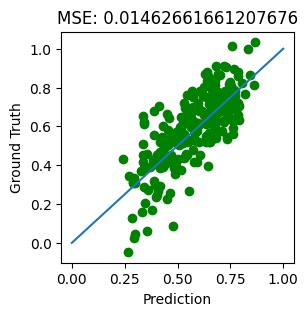

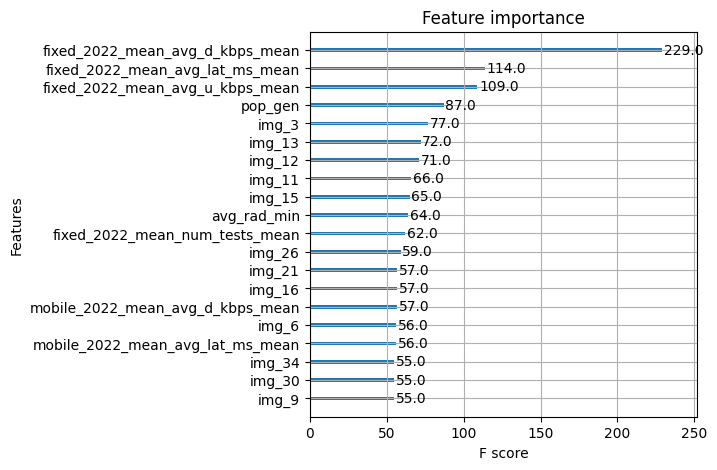

In [10]:
# After quick grid search below
params = {
    'learning_rate': 0.1,    'n_estimators': 100,    'max_depth': 6,    'min_child_weight': 1,    'gamma': 0,
    'subsample': 1,    'colsample_bytree': 0.8,    'reg_lambda': 1,    'reg_alpha': 0,    'objective': 'reg:squarederror',
    'random_state': 42,    'device':'cuda',    'tree_method':'hist',    # 'enable_categorical':True
}

model_xgb_base = xgb.XGBRegressor(**params)
model_xgb_base.fit(pd.concat([X_train_img,X_val_img],axis=0), np.hstack([y_train,y_val]))

# model_xgb_reg.set_params(device="cpu") # To prevent warning messages of model and array residing on different devices
pred = model_xgb_base.predict(X_test_img)
mse = mean_squared_error(y_test,pred)
print('Testing performance')
print(f'MSE: {mse:.4f}')

fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.scatter(pred,y_test, c='g')
ax.plot([0,1],[0,1])
ax.set_title(f'MSE: {mse}')
ax.set_xlabel('Prediction')
ax.set_ylabel('Ground Truth');

fig2, ax2 =plt.subplots(1,1,figsize=(5,5))
xgb.plot_importance(model_xgb_base,max_num_features=20,ax=ax2)

Testing performance
MSE: 0.0152


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

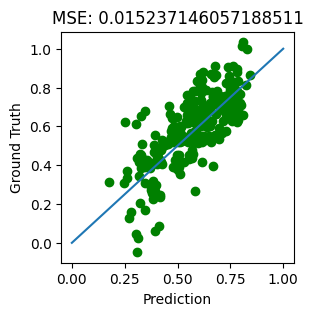

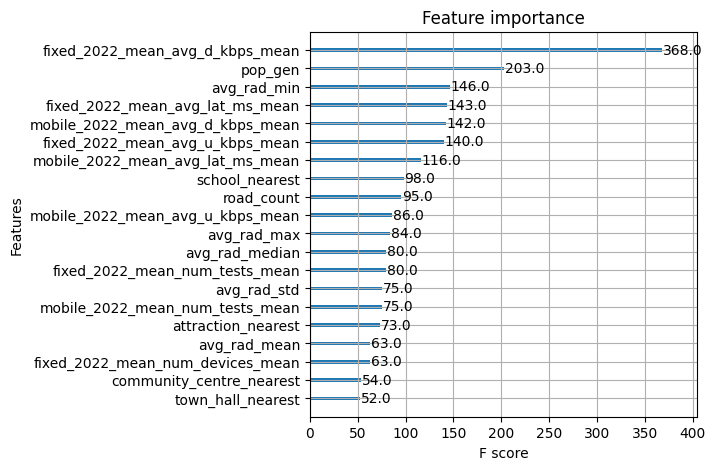

In [21]:
# After quick grid search below
params = {
    'learning_rate': 0.1,    'n_estimators': 100,    'max_depth': 6,    'min_child_weight': 1,    'gamma': 0,
    'subsample': 1,    'colsample_bytree': 0.8,    'reg_lambda': 1,    'reg_alpha': 0,    'objective': 'reg:squarederror',
    'random_state': 42,    'device':'cuda',    'tree_method':'hist',    # 'enable_categorical':True
}

model_xgb_base = xgb.XGBRegressor(**params)
model_xgb_base.fit(pd.concat([X_train,X_val],axis=0), np.hstack([y_train,y_val]))

# model_xgb_reg.set_params(device="cpu") # To prevent warning messages of model and array residing on different devices
pred = model_xgb_base.predict(X_test)
mse = mean_squared_error(y_test,pred)
print('Testing performance')
print(f'MSE: {mse:.4f}')

fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.scatter(pred,y_test, c='g')
ax.plot([0,1],[0,1])
ax.set_title(f'MSE: {mse}')
ax.set_xlabel('Prediction')
ax.set_ylabel('Ground Truth');

fig2, ax2 =plt.subplots(1,1,figsize=(5,5))
xgb.plot_importance(model_xgb_base,max_num_features=20,ax=ax2)

##### Experiment with different number of PCA components

In [11]:
mses = []
for ncomp in range(10,400,5):
    # Create copies of original
    train_img_feat = train_img_feat_raw.copy()
    val_img_feat = val_img_feat_raw.copy()
    test_img_feat = test_img_feat_raw.copy()
    
    # Scale before PCA
    scaler_img = StandardScaler()
    scaler_img.fit(np.vstack([train_img_feat,val_img_feat]))
    train_img_feat = scaler_img.transform(train_img_feat)
    val_img_feat = scaler_img.transform(val_img_feat)
    test_img_feat = scaler_img.transform(test_img_feat)
    
    # Perform PCA
    pca_img = PCA(n_components=ncomp)
    pca_img.fit(np.vstack([train_img_feat,val_img_feat]))
    train_img_feat = pca_img.transform(train_img_feat)
    val_img_feat = pca_img.transform(val_img_feat)
    test_img_feat = pca_img.transform(test_img_feat)

    # Get targets
    y_train = df_target.loc[ind_train,'target']
    y_val = df_target.loc[ind_val,'target']
    y_test = df_target.loc[ind_test,'target']
    
    # Get other features
    datapath = "data/"
    X_all = pd.read_csv(os.path.join(datapath,'X.csv'))
    X_all.drop(columns=['DHSCLUST'],inplace=True)
    X_train = X_all.loc[ind_train,:]
    X_val = X_all.loc[ind_val,:]
    X_test = X_all.loc[ind_test,:]
    
    # Get image features
    X_train_img = pd.concat([X_train,
                         pd.DataFrame(train_img_feat,
                                      columns=[f'img_{i}' for i in range(train_img_feat.shape[1])],
                                      index=X_train.index)],
                        axis=1)
    X_val_img = pd.concat([X_val,
                         pd.DataFrame(val_img_feat,
                                      columns=[f'img_{i}' for i in range(val_img_feat.shape[1])],
                                      index=X_val.index)],
                        axis=1)
    X_test_img = pd.concat([X_test,
                         pd.DataFrame(test_img_feat,
                                      columns=[f'img_{i}' for i in range(test_img_feat.shape[1])],
                                      index=X_test.index)],
                        axis=1)
    
    # After quick grid search below
    params = {
        'learning_rate': 0.1,    'n_estimators': 100,    'max_depth': 6,    'min_child_weight': 1,    'gamma': 0,
        'subsample': 1,    'colsample_bytree': 0.8,    'reg_lambda': 1,    'reg_alpha': 0,    'objective': 'reg:squarederror',
        'random_state': 42,    'device':'cuda',    'tree_method':'hist',    # 'enable_categorical':True
    }
    
    model_xgb_base = xgb.XGBRegressor(**params)
    model_xgb_base.fit(pd.concat([X_train_img,X_val_img],axis=0), np.hstack([y_train,y_val]))
    
    # model_xgb_reg.set_params(device="cpu") # To prevent warning messages of model and array residing on different devices
    pred = model_xgb_base.predict(X_test_img)
    mse = mean_squared_error(y_test,pred)
    mses.append(mse)

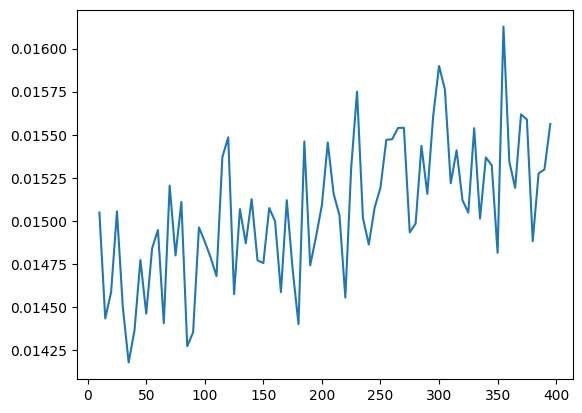

In [17]:
plt.plot(range(10,400,5),np.array(mses))

(0.0, 0.2)

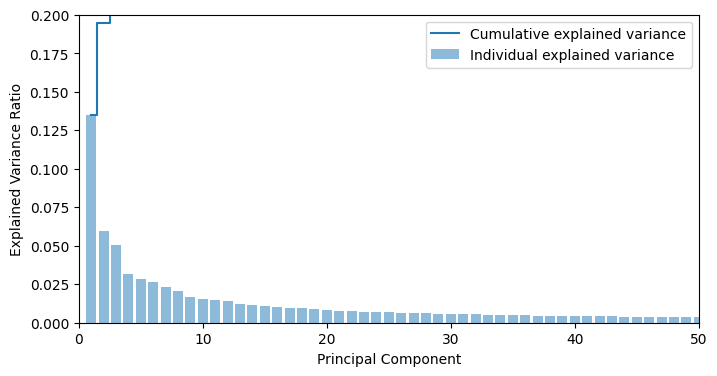

In [20]:
# Explained variance ratio (as a proportion of total variance)
explained_variance_ratio = pca_img.explained_variance_ratio_
# print("Explained Variance Ratio:", explained_variance_ratio)

# Cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
# print("Cumulative Explained Variance:", cumulative_explained_variance)

# Plot the explained variance ratio
plt.figure(figsize=(8, 4))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, where='mid', label='Cumulative explained variance')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.legend(loc='best')
plt.xlim([0,50])
plt.ylim([0,0.2])

##### use ncomp=50

In [227]:
# Load data
target_path = 'data'
df_target_raw = pd.read_csv(os.path.join(target_path,'y.csv'))\
    .rename(columns={'Wealth_Index':'target'})
df_target_raw['filename'] = df_target_raw['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_target_raw.drop(columns='DHSCLUST', inplace=True)
df_target_raw = df_target_raw.astype({'target':'float32'})

# Get other features
datapath = "data/"
X_all = pd.read_csv(os.path.join(datapath,'X.csv'))
X_all.drop(columns=['DHSCLUST'],inplace=True)
X_all.dropna(inplace=True)

# Perform train test split
ind_training, ind_test = train_test_split(X_all.index, test_size=0.2, random_state=42)
ind_train, ind_val = train_test_split(ind_training, test_size=0.2, random_state=42)

X_train = X_all.loc[ind_train,:]
X_val = X_all.loc[ind_val,:]
X_test = X_all.loc[ind_test,:]

# Load the full dataset
df_target = df_target_raw.copy()
image_folder = 'data/daysat/2022/'

# MinMaxScale to target
scaler = MinMaxScaler()
df_target.loc[ind_train.union(ind_val),'target'] = scaler.fit_transform(df_target.loc[ind_train.union(ind_val),['target']])
df_target.loc[ind_test,'target'] = scaler.transform(df_target.loc[ind_test,['target']])

# Get targets
y_train = df_target.loc[ind_train,'target']
y_val = df_target.loc[ind_val,'target']
y_test = df_target.loc[ind_test,'target']

In [228]:
# Custom Dataset class
class RegressionDataset(Dataset):
    def __init__(self, image_folder, targets_df, transform=None):
        self.image_folder = image_folder
        self.targets_df = targets_df
        self.transform = transform
        self.image_files = targets_df['filename'].tolist()
        self.targets = targets_df['target']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

model_base = timm.create_model(
    'vit_base_patch16_224.dino',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model_base)
model_transforms = timm.data.create_transform(**data_config, is_training=False)

# Create datasets
train_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target.loc[ind_train,:].reset_index(drop=True),transform=model_transforms)
val_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target.loc[ind_val,:].reset_index(drop=True),transform=model_transforms)
test_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target.loc[ind_test,:].reset_index(drop=True),transform=model_transforms)

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=False, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)
}

# Extract image features
model_base.eval()  # Set the model to evaluation mode

train_img_feat=[]
with torch.no_grad():
    for inputs, labels in dataloaders['train']:
        inputs = inputs
        outputs = model_base(inputs)
        train_img_feat.append(outputs.cpu().numpy())
train_img_feat_raw = np.concatenate(train_img_feat, axis=0)

val_img_feat=[]
with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs
        outputs = model_base(inputs)
        val_img_feat.append(outputs.cpu().numpy())
val_img_feat_raw = np.concatenate(val_img_feat, axis=0)

test_img_feat=[]
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs
        outputs = model_base(inputs)
        test_img_feat.append(outputs.cpu().numpy())
test_img_feat_raw = np.concatenate(test_img_feat, axis=0)

In [229]:
# Create copies of original
train_img_feat = train_img_feat_raw.copy()
val_img_feat = val_img_feat_raw.copy()
test_img_feat = test_img_feat_raw.copy()

# Scale before PCA
scaler_img = StandardScaler()
scaler_img.fit(np.vstack([train_img_feat,val_img_feat]))
train_img_feat = scaler_img.transform(train_img_feat)
val_img_feat = scaler_img.transform(val_img_feat)
test_img_feat = scaler_img.transform(test_img_feat)

# Perform PCA
pca_img = PCA(n_components=50)
pca_img.fit(np.vstack([train_img_feat,val_img_feat]))
print(np.sum(pca_img.explained_variance_ratio_))
train_img_feat = pca_img.transform(train_img_feat)
val_img_feat = pca_img.transform(val_img_feat)
test_img_feat = pca_img.transform(test_img_feat)

0.6729606


In [230]:
# Get image features
X_train_img = pd.concat([X_train,
                     pd.DataFrame(train_img_feat,
                                  columns=[f'img_{i}' for i in range(train_img_feat.shape[1])],
                                  index=X_train.index)],
                    axis=1)
X_val_img = pd.concat([X_val,
                     pd.DataFrame(val_img_feat,
                                  columns=[f'img_{i}' for i in range(val_img_feat.shape[1])],
                                  index=X_val.index)],
                    axis=1)
X_test_img = pd.concat([X_test,
                     pd.DataFrame(test_img_feat,
                                  columns=[f'img_{i}' for i in range(test_img_feat.shape[1])],
                                  index=X_test.index)],
                    axis=1)

In [231]:
image_feature_names = [col for col in X_train_img.columns if 'img' in col]
HRSL_feature_names = ['pop_gen']
OOKLA_feature_names = ['fixed_2022_mean_avg_d_kbps_mean','fixed_2022_mean_avg_u_kbps_mean',
                       'fixed_2022_mean_avg_lat_ms_mean','fixed_2022_mean_num_tests_mean',
                       'fixed_2022_mean_num_devices_mean','mobile_2022_mean_avg_d_kbps_mean',
                       'mobile_2022_mean_avg_u_kbps_mean','mobile_2022_mean_avg_lat_ms_mean',
                       'mobile_2022_mean_num_tests_mean','mobile_2022_mean_num_devices_mean']
nightlight_feature_names = ['avg_rad_min','avg_rad_max','avg_rad_mean',
                            'avg_rad_std','avg_rad_median']
non_OSM_feature_names = image_feature_names+HRSL_feature_names+OOKLA_feature_names+nightlight_feature_names
non_OSM_n_img_feature_names = HRSL_feature_names+OOKLA_feature_names+nightlight_feature_names
OSM_feature_names = list(set(X_train.columns)-set(non_OSM_feature_names))

Testing performance
MSE: 0.0105


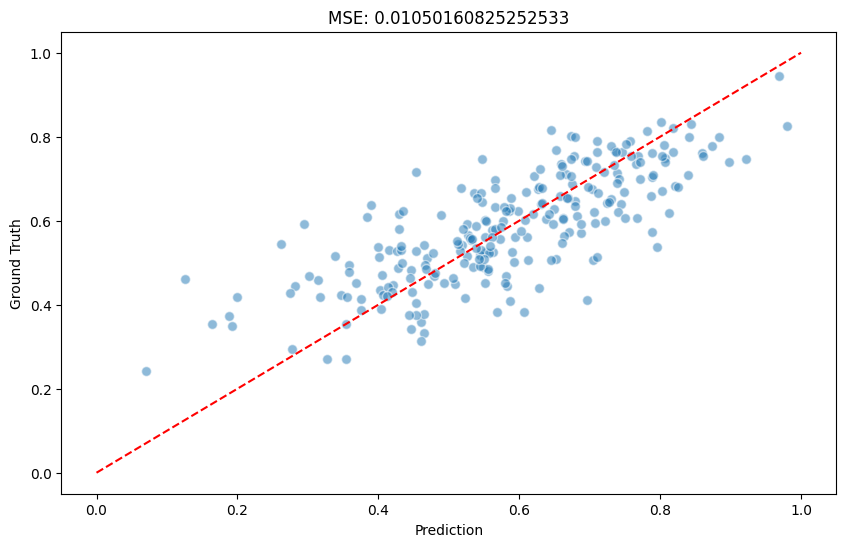

In [232]:
# XGBoost
params = {
    'learning_rate': 0.1,    'n_estimators': 100,    'max_depth': 6,    'min_child_weight': 1,    'gamma': 0,
    'subsample': 1,    'colsample_bytree': 0.8,    'reg_lambda': 1,    'reg_alpha': 0,    'objective': 'reg:squarederror',
    'random_state': 42,    'device':'cuda',    'tree_method':'hist',    # 'enable_categorical':True
}

feature_names = OOKLA_feature_names + nightlight_feature_names + OSM_feature_names

model_xgb_base = xgb.XGBRegressor(**params)
model_xgb_base.fit(pd.concat([X_train_img,X_val_img],axis=0)[feature_names], np.hstack([y_train,y_val]))

model_xgb_base.set_params(device="cpu") # To prevent warning messages of model and array residing on different devices
pred = model_xgb_base.predict(X_test_img[feature_names])
mse = mean_squared_error(y_test,pred)
print('Testing performance')
print(f'MSE: {mse:.4f}')

fig, ax = plt.subplots(1,1,figsize=(10, 6))

ax.scatter(y_test, pred, alpha=0.5, edgecolors='w', s=50)
ax.plot([0,1], [0,1], color='red', linestyle='--', label='Ideal Line')

ax.set_title(f'True Labels vs. Predictions, MSE: {mse}')
ax.set_title(f'MSE: {mse}')
ax.set_xlabel('Prediction')
ax.set_ylabel('Ground Truth');

Testing performance
MSE: 0.0125


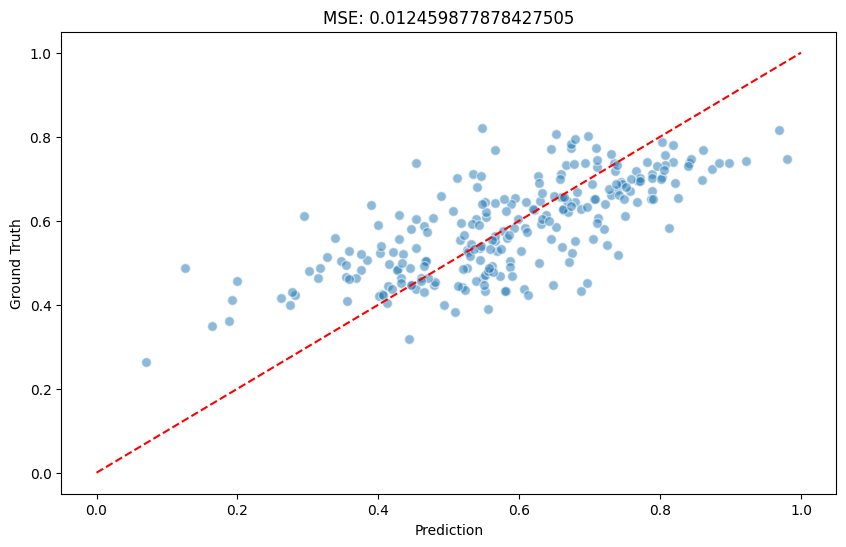

In [233]:
# XGBoost
params = {
    'learning_rate': 0.1,    'n_estimators': 100,    'max_depth': 6,    'min_child_weight': 1,    'gamma': 0,
    'subsample': 1,    'colsample_bytree': 0.8,    'reg_lambda': 1,    'reg_alpha': 0,    'objective': 'reg:squarederror',
    'random_state': 42,    'device':'cuda',    'tree_method':'hist',    # 'enable_categorical':True
}

feature_names = image_feature_names

model_xgb_base = xgb.XGBRegressor(**params)
model_xgb_base.fit(pd.concat([X_train_img,X_val_img],axis=0)[feature_names], np.hstack([y_train,y_val]))

model_xgb_base.set_params(device="cpu") # To prevent warning messages of model and array residing on different devices
pred = model_xgb_base.predict(X_test_img[feature_names])
mse = mean_squared_error(y_test,pred)
print('Testing performance')
print(f'MSE: {mse:.4f}')

fig, ax = plt.subplots(1,1,figsize=(10, 6))

ax.scatter(y_test, pred, alpha=0.5, edgecolors='w', s=50)
ax.plot([0,1], [0,1], color='red', linestyle='--', label='Ideal Line')

ax.set_title(f'True Labels vs. Predictions, MSE: {mse}')
ax.set_title(f'MSE: {mse}')
ax.set_xlabel('Prediction')
ax.set_ylabel('Ground Truth');

Testing performance
MSE: 0.0111


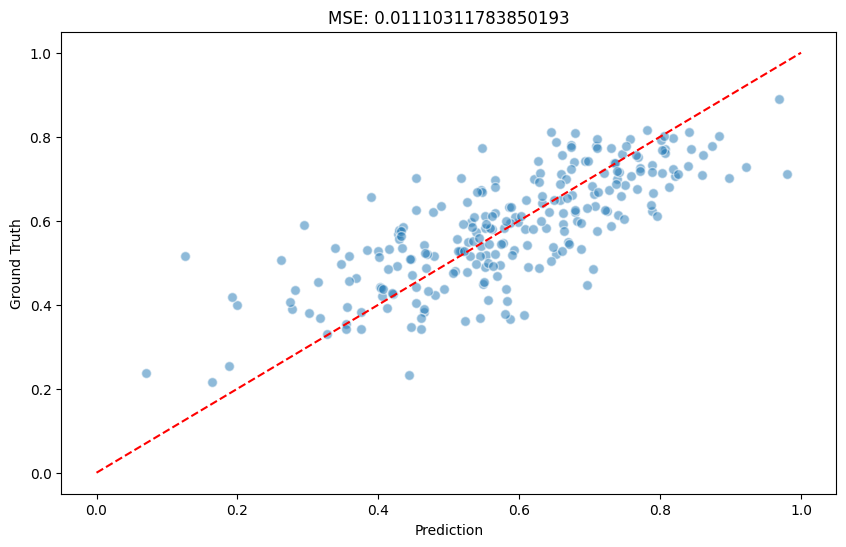

In [234]:
# XGBoost
params = {
    'learning_rate': 0.1,    'n_estimators': 100,    'max_depth': 6,    'min_child_weight': 1,    'gamma': 0,
    'subsample': 1,    'colsample_bytree': 0.8,    'reg_lambda': 1,    'reg_alpha': 0,    'objective': 'reg:squarederror',
    'random_state': 42,    'device':'cuda',    'tree_method':'hist',    # 'enable_categorical':True
}

feature_names = image_feature_names + OOKLA_feature_names + nightlight_feature_names + OSM_feature_names

model_xgb_base = xgb.XGBRegressor(**params)
model_xgb_base.fit(pd.concat([X_train_img,X_val_img],axis=0)[feature_names], np.hstack([y_train,y_val]))

model_xgb_base.set_params(device="cpu") # To prevent warning messages of model and array residing on different devices
pred = model_xgb_base.predict(X_test_img[feature_names])
mse = mean_squared_error(y_test,pred)
print('Testing performance')
print(f'MSE: {mse:.4f}')

fig, ax = plt.subplots(1,1,figsize=(10, 6))

ax.scatter(y_test, pred, alpha=0.5, edgecolors='w', s=50)
ax.plot([0,1], [0,1], color='red', linestyle='--', label='Ideal Line')

ax.set_title(f'True Labels vs. Predictions, MSE: {mse}')
ax.set_title(f'MSE: {mse}')
ax.set_xlabel('Prediction')
ax.set_ylabel('Ground Truth');

In [235]:
all_feature_groups = {'OOKLA':OOKLA_feature_names,
                      'nightlight':nightlight_feature_names,
                      'image':image_feature_names,
                      'HRSL':HRSL_feature_names,
                      'OSM':OSM_feature_names}

# Generate all possible combinations of the items
combinations = []
for r in range(1, len(all_feature_groups) + 1):
    for combination in itertools.combinations(all_feature_groups.keys(), r):
        # Create a dictionary to represent the row
        row = {'OOKLA':0, 'nightlight':0, 'image':0, 'HRSL':0, 'OSM':0}
        combined_list = []
        
        for item in combination:
            row[item] = 1  # Mark the presence of this list
            combined_list.extend(all_feature_groups[item])  # Concatenate the lists
        
        # Add a label for the y-tick
        row['Label'] = ','.join(combination)
        
        row['feature_names'] = combined_list  # Store the combined list as well
        combinations.append(row)

df = pd.DataFrame(combinations)
df['MSE'] = 0

In [236]:
# After quick grid search below
params = {
    'learning_rate': 0.1,    'n_estimators': 100,    'max_depth': 6,    'min_child_weight': 1,    'gamma': 0,
    'subsample': 1,    'colsample_bytree': 0.8,    'reg_lambda': 1,    'reg_alpha': 0,    'objective': 'reg:squarederror',
    'random_state': 42,    'device':'cuda',    'tree_method':'hist',    # 'enable_categorical':True
}

for i, feature_names in enumerate(df['feature_names']):
    model_xgb_base = xgb.XGBRegressor(**params)
    # model_xgb_base.fit(X_trainval_img[feature_names], y_trainval)
    model_xgb_base.fit(pd.concat([X_train_img,X_val_img],axis=0)[feature_names], np.hstack([y_train,y_val]))
    
    model_xgb_base.set_params(device="cpu") # To prevent warning messages of model and array residing on different devices
    pred = model_xgb_base.predict(X_test_img[feature_names])
    
    mse = mean_squared_error(y_test,pred)
    df.loc[i,'MSE'] = mse

/tmp/ipykernel_119528/591801377.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.011853043921291828' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i,'MSE'] = mse


In [237]:
df.drop(columns=['OOKLA','nightlight','image','HRSL','OSM','feature_names'])[df['image']==1].sort_values('MSE')

,Label,MSE
28,"OOKLA,image,HRSL,OSM",0.010121
19,"OOKLA,image,OSM",0.010370
30,"OOKLA,nightlight,image,HRSL,OSM",0.010447
24,"image,HRSL,OSM",0.010533
25,"OOKLA,nightlight,image,HRSL",0.010575
15,"OOKLA,nightlight,image",0.010621
26,"OOKLA,nightlight,image,OSM",0.010775
13,"image,OSM",0.010784
18,"OOKLA,image,HRSL",0.010933
6,"OOKLA,image",0.010987


In [238]:
df.drop(columns=['OOKLA','nightlight','image','HRSL','OSM','feature_names']).sort_values('MSE')

,Label,MSE
8,"OOKLA,OSM",0.009556
20,"OOKLA,HRSL,OSM",0.009692
28,"OOKLA,image,HRSL,OSM",0.010121
19,"OOKLA,image,OSM",0.010370
30,"OOKLA,nightlight,image,HRSL,OSM",0.010447
17,"OOKLA,nightlight,OSM",0.010502
24,"image,HRSL,OSM",0.010533
25,"OOKLA,nightlight,image,HRSL",0.010575
15,"OOKLA,nightlight,image",0.010621
27,"OOKLA,nightlight,HRSL,OSM",0.010765


In [239]:
df.drop(columns=['OOKLA','nightlight','image','HRSL','OSM','feature_names'])[df['OSM']==1].drop(columns=['Label']).mean()

MSE    0.010663
dtype: float64

In [240]:
df.drop(columns=['OOKLA','nightlight','image','HRSL','OSM','feature_names'])[df['OOKLA']==1].drop(columns=['Label']).mean()

MSE    0.010767
dtype: float64

In [241]:
df.drop(columns=['OOKLA','nightlight','image','HRSL','OSM','feature_names'])[df['image']==1].drop(columns=['Label']).mean()

MSE    0.011092
dtype: float64

In [242]:
df.drop(columns=['OOKLA','nightlight','image','HRSL','OSM','feature_names'])[df['nightlight']==1].drop(columns=['Label']).mean()

MSE    0.011443
dtype: float64

In [243]:
df.drop(columns=['OOKLA','nightlight','image','HRSL','OSM','feature_names'])[df['HRSL']==1].drop(columns=['Label']).mean()

MSE    0.012364
dtype: float64

#### daysat direct on xgboost - vit feature extraction + trained MLP

feature extraction with training to predict wealth, but feels like not much improvement either.

In [179]:
# Load data
target_path = 'data'
df_target_raw = pd.read_csv(os.path.join(target_path,'y.csv'))\
    .rename(columns={'Wealth_Index':'target'})
df_target_raw['filename'] = df_target_raw['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_target_raw.drop(columns='DHSCLUST', inplace=True)
df_target_raw = df_target_raw.astype({'target':'float32'})

# Perform train test split
ind_training, ind_test = train_test_split(df_target_raw.index, test_size=0.2, random_state=42)
ind_train, ind_val = train_test_split(ind_training, test_size=0.2, random_state=42)

# Load the full dataset
df_target = df_target_raw.copy()
image_folder = 'data/daysat/2022/'

# MinMaxScale to target
scaler = MinMaxScaler()
df_target.loc[ind_train.union(ind_val),'target'] = scaler.fit_transform(df_target.loc[ind_train.union(ind_val),['target']])
df_target.loc[ind_test,'target'] = scaler.transform(df_target.loc[ind_test,['target']])

In [180]:
class VitBaseForRegression(nn.Module):
    def __init__(self, base_model):
        super(VitBaseForRegression, self).__init__()
        self.backbone = base_model
        # Add a regression head
        self.fc = nn.Sequential(
            nn.Linear(base_model.num_features, 1),
            nn.Sigmoid()
        )

        # Freeze the weights of the backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
            
    def forward(self, x):
        features = self.backbone(x)
        outputs = self.fc(features)
        return outputs


# Custom Dataset class
class RegressionDataset(Dataset):
    def __init__(self, image_folder, targets_df, transform=None):
        self.image_folder = image_folder
        self.targets_df = targets_df
        self.transform = transform
        self.image_files = targets_df['filename'].tolist()
        self.targets = targets_df['target']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

# Training code
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,verbose=0,plot_curves=True):
    since = time.time()

    df = pd.DataFrame({'trainval':np.zeros([num_epochs]), 'test':np.zeros([num_epochs])})
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = 1e10

        for epoch in range(num_epochs):
            if verbose == 1:
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['trainval', 'test']:
                if phase == 'trainval':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in trainval
                    with torch.set_grad_enabled(phase == 'trainval'):
                        outputs = model(inputs).squeeze()
                        loss = criterion(outputs, labels.squeeze())

                        # backward + optimize only if in training phase
                        if phase == 'trainval':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                if phase == 'trainval':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]

                if verbose == 1:
                    print(f'{phase} Loss: {epoch_loss:.4f}')
                df.loc[epoch,phase] = epoch_loss

                # deep copy the model
                if phase == 'test' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            if verbose == 1:
                print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        if plot_curves:
            df.plot()
        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, df

In [181]:
# Create model
model_base = timm.create_model(
    'vit_base_patch16_224.dino',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model_base)
model_transforms = timm.data.create_transform(**data_config, is_training=False)

# Create regression model
model_reg = VitBaseForRegression(model_base)

# Use GPU training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_reg.to(device);

criterion = nn.MSELoss()
optimizer = optim.SGD(model_reg.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# transform
trainval_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),               # Randomly flip horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),                 # Randomly flip vertically with a probability of 0.5
    transforms.RandomRotation(degrees=30),                # Randomly rotate within the range [-30, 30] degrees
    transforms.RandomAffine(degrees=0, shear=10),         # Apply shearing with a range of [-10, 10] degrees
    # transforms.ToTensor(),                                # Convert the image to a tensor
    model_transforms
])

test_transform = model_transforms

data_transforms = {
    'trainval': trainval_transform,
    'test': test_transform
}

# Create datasets
trainval_dataset = RegressionDataset(image_folder=image_folder,
                                     targets_df=df_target.loc[ind_train.union(ind_val),:].reset_index(drop=True),
                                     transform=data_transforms['trainval'])
test_dataset = RegressionDataset(image_folder=image_folder,
                                 targets_df=df_target.loc[ind_test,:].reset_index(drop=True),
                                 transform=data_transforms['test'])

# Determine the sizes for the different datasets
total_size, trainval_size, train_size, val_size, test_size = len(df_target), len(ind_train) + len(ind_val), len(ind_train), len(ind_val), len(ind_test)
dataset_sizes = {'trainval':trainval_size, 'test': test_size}

# Create DataLoader instances
dataloaders = {
    'trainval': DataLoader(trainval_dataset, batch_size=8, shuffle=True, num_workers=4,drop_last=False),
    'trainval_eval': DataLoader(trainval_dataset, batch_size=8, shuffle=False, num_workers=4,drop_last=False),
    'test': DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4, drop_last=False)
    
}

Training complete in 1m 19s


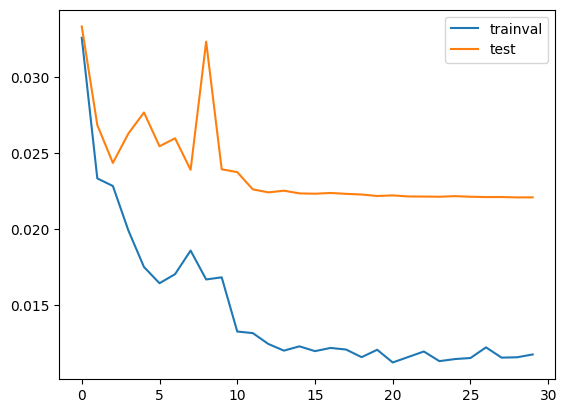

In [182]:
# Train model
model_reg, df = train_model(model_reg, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=30,verbose=0,plot_curves=True)

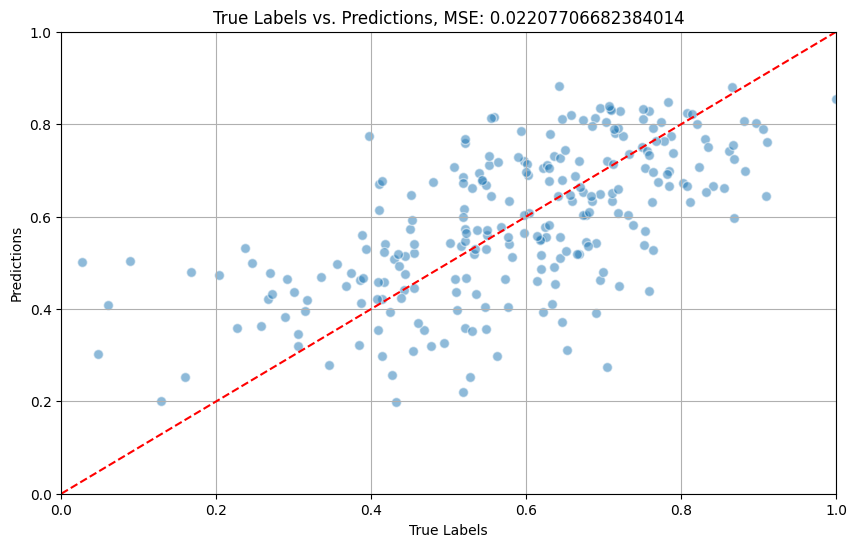

In [183]:
# Initialize lists to store the outputs and labels
all_outputs = []
all_labels = []

model_reg.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)  # Ensure labels are also on the correct device
        outputs = model_reg(inputs)

        # Collect outputs and labels
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all collected outputs and labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([0,1], [0,1], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
plt.xlim([0,1])
plt.ylim([0,1]);

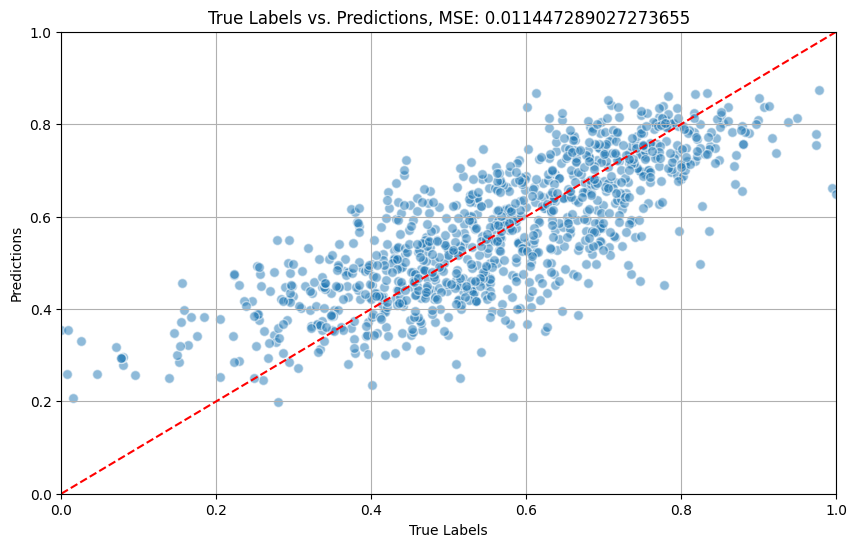

In [184]:
# Initialize lists to store the outputs and labels
all_outputs = []
all_labels = []

model_reg.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['trainval_eval']:
        inputs = inputs.to(device)
        labels = labels.to(device)  # Ensure labels are also on the correct device
        outputs = model_reg(inputs)

        # Collect outputs and labels
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all collected outputs and labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([0,1], [0,1], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
plt.xlim([0,1])
plt.ylim([0,1]);

In [185]:
# Initialize lists to store the outputs and labels
return_nodes = {
    "fc.1": "lin_out"      # taking from this rather than from fc.0 seems better
}
model_reg_extractor = create_feature_extractor(model_reg, return_nodes=return_nodes)
model_reg_extractor.eval()  # Set the model to evaluation mode

all_outputs = []
with torch.no_grad():
    for inputs, labels in dataloaders['trainval_eval']:
        inputs = inputs.to(device)
        outputs = model_reg_extractor(inputs)
        all_outputs.append(outputs['lin_out'].squeeze().cpu().numpy())
trainval_img_feat = np.concatenate(all_outputs, axis=0)

all_outputs = []
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        outputs = model_reg_extractor(inputs)
        all_outputs.append(outputs['lin_out'].squeeze().cpu().numpy())
test_img_feat = np.concatenate(all_outputs, axis=0)

In [186]:
# Get targets
y_trainval = df_target.loc[ind_train.union(ind_val),'target']
y_test = df_target.loc[ind_test,'target']

# Get other features
datapath = "data/"
X_all = pd.read_csv(os.path.join(datapath,'X.csv'))
X_all.drop(columns=['DHSCLUST'],inplace=True)
X_trainval = X_all.loc[ind_train.union(ind_val),:]
X_test = X_all.loc[ind_test,:]

# Get image features
X_trainval_img = pd.concat([X_trainval,
                     pd.DataFrame(trainval_img_feat,
                                  columns=['img'],
                                  index=X_trainval.index)],
                    axis=1)

X_test_img = pd.concat([X_test,
                     pd.DataFrame(test_img_feat,
                                  columns=['img'],
                                  index=X_test.index)],
                    axis=1)

In [187]:
image_feature_names = ['img']
HRSL_feature_names = ['pop_gen']
OOKLA_feature_names = ['fixed_2022_mean_avg_d_kbps_mean','fixed_2022_mean_avg_u_kbps_mean',
                       'fixed_2022_mean_avg_lat_ms_mean','fixed_2022_mean_num_tests_mean',
                       'fixed_2022_mean_num_devices_mean','mobile_2022_mean_avg_d_kbps_mean',
                       'mobile_2022_mean_avg_u_kbps_mean','mobile_2022_mean_avg_lat_ms_mean',
                       'mobile_2022_mean_num_tests_mean','mobile_2022_mean_num_devices_mean']
nightlight_feature_names = ['avg_rad_min','avg_rad_max','avg_rad_mean',
                            'avg_rad_std','avg_rad_median']
non_OSM_feature_names = image_feature_names+HRSL_feature_names+OOKLA_feature_names+nightlight_feature_names
non_OSM_n_img_feature_names = HRSL_feature_names+OOKLA_feature_names+nightlight_feature_names
OSM_feature_names = list(set(X_trainval.columns)-set(non_OSM_feature_names))

Testing performance
MSE: 0.0154


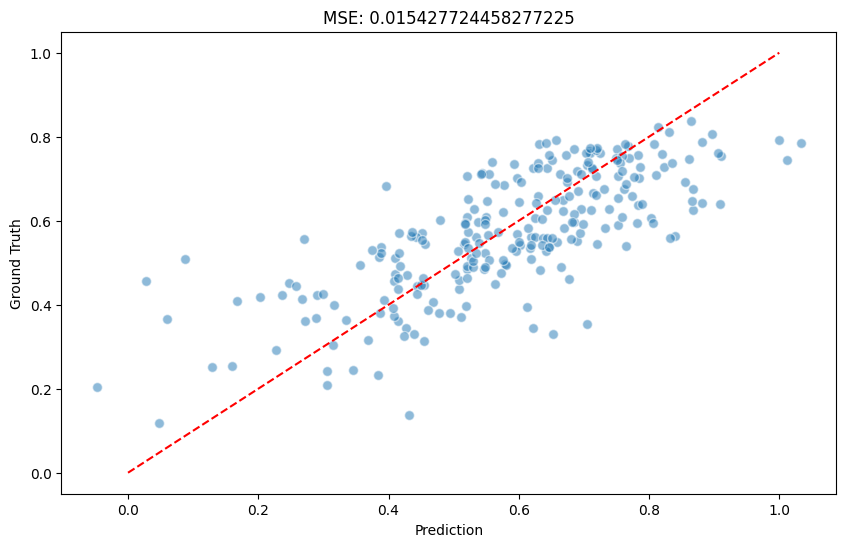

In [188]:
# XGBoost
params = {
    'learning_rate': 0.1,    'n_estimators': 100,    'max_depth': 6,    'min_child_weight': 1,    'gamma': 0,
    'subsample': 1,    'colsample_bytree': 0.8,    'reg_lambda': 1,    'reg_alpha': 0,    'objective': 'reg:squarederror',
    'random_state': 42,    'device':'cuda',    'tree_method':'hist',    # 'enable_categorical':True
}

feature_names = image_feature_names + OOKLA_feature_names + nightlight_feature_names + OSM_feature_names

model_xgb_base = xgb.XGBRegressor(**params)
model_xgb_base.fit(X_trainval_img[feature_names], y_trainval)

# model_xgb_reg.set_params(device="cpu") # To prevent warning messages of model and array residing on different devices
pred = model_xgb_base.predict(X_test_img[feature_names])
mse = mean_squared_error(y_test,pred)
print('Testing performance')
print(f'MSE: {mse:.4f}')

fig, ax = plt.subplots(1,1,figsize=(10, 6))

ax.scatter(y_test, pred, alpha=0.5, edgecolors='w', s=50)
ax.plot([0,1], [0,1], color='red', linestyle='--', label='Ideal Line')

ax.set_title(f'True Labels vs. Predictions, MSE: {mse}')
ax.set_title(f'MSE: {mse}')
ax.set_xlabel('Prediction')
ax.set_ylabel('Ground Truth');

In [47]:
all_feature_groups = {'OOKLA':OOKLA_feature_names,
                      'nightlight':nightlight_feature_names,
                      'image':image_feature_names,
                      'HRSL':HRSL_feature_names,
                      'OSM':OSM_feature_names}

# Generate all possible combinations of the items
combinations = []
for r in range(1, len(all_feature_groups) + 1):
    for combination in itertools.combinations(all_feature_groups.keys(), r):
        # Create a dictionary to represent the row
        row = {'OOKLA':0, 'nightlight':0, 'image':0, 'HRSL':0, 'OSM':0}
        combined_list = []
        
        for item in combination:
            row[item] = 1  # Mark the presence of this list
            combined_list.extend(all_feature_groups[item])  # Concatenate the lists
        
        # Add a label for the y-tick
        row['Label'] = ','.join(combination)
        
        row['feature_names'] = combined_list  # Store the combined list as well
        combinations.append(row)

df = pd.DataFrame(combinations)
df['MSE'] = 0

In [48]:
# After quick grid search below
params = {
    'learning_rate': 0.1,    'n_estimators': 100,    'max_depth': 6,    'min_child_weight': 1,    'gamma': 0,
    'subsample': 1,    'colsample_bytree': 0.8,    'reg_lambda': 1,    'reg_alpha': 0,    'objective': 'reg:squarederror',
    'random_state': 42,    'device':'cuda',    'tree_method':'hist',    # 'enable_categorical':True
}

for i, feature_names in enumerate(df['feature_names']):
    model_xgb_base = xgb.XGBRegressor(**params)
    model_xgb_base.fit(X_trainval_img[feature_names], y_trainval)
    
    # model_xgb_reg.set_params(device="cpu") # To prevent warning messages of model and array residing on different devices
    pred = model_xgb_base.predict(X_test_img[feature_names])
    mse = mean_squared_error(y_test,pred)
    df.loc[i,'MSE'] = mse
    # print('Testing performance')
    # print(f'MSE: {mse:.4f}')
    
    # fig, ax = plt.subplots(1,1,figsize=(3,3))
    # ax.scatter(pred,y_test, c='g')
    # ax.plot([0,1],[0,1])
    # ax.set_title(f'MSE: {mse}')
    # ax.set_xlabel('Prediction')
    # ax.set_ylabel('Ground Truth');
    
    # fig2, ax2 =plt.subplots(1,1,figsize=(5,5))
    # xgb.plot_importance(model_xgb_base,max_num_features=20,ax=ax2)

/home/tfc/anaconda3/envs/sat_dl/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:10:11] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/tmp/ipykernel_102093/3541641701.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.018633732572197914' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i,'MSE'] = mse


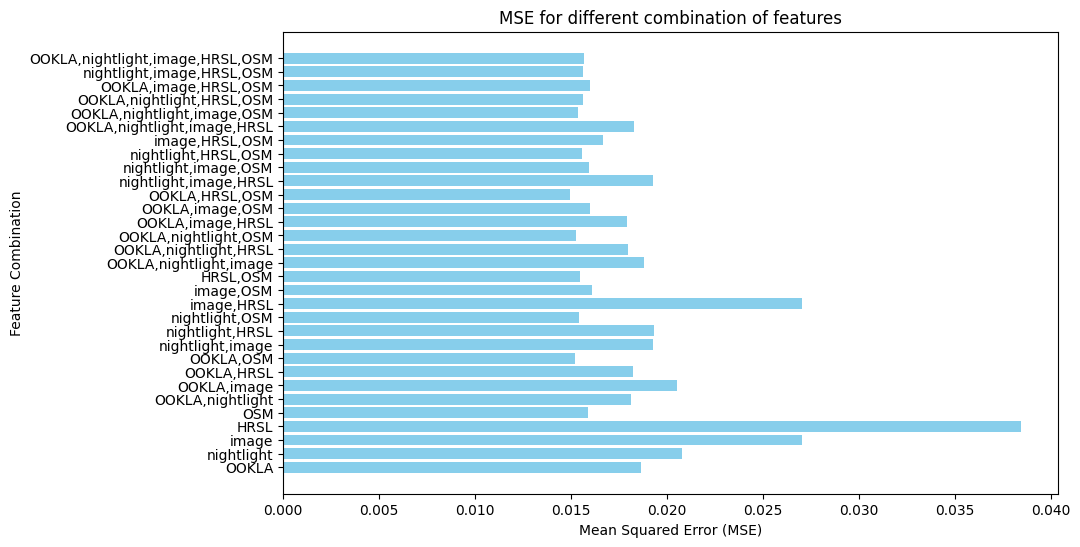

In [49]:
# Plotting
plt.figure(figsize=(10, 6))
plt.barh(df['Label'], df['MSE'], color='skyblue')
plt.xlabel('Mean Squared Error (MSE)')
plt.ylabel('Feature Combination')
plt.title('MSE for different combination of features')

# Show the plot
plt.show()

In [50]:
df.drop(columns=['OOKLA','nightlight','image','HRSL','OSM','feature_names'])[df['image']==1].sort_values('MSE')

,Label,MSE
26,"OOKLA,nightlight,image,OSM",0.015367
29,"nightlight,image,HRSL,OSM",0.015645
30,"OOKLA,nightlight,image,HRSL,OSM",0.015692
22,"nightlight,image,OSM",0.015929
19,"OOKLA,image,OSM",0.015974
28,"OOKLA,image,HRSL,OSM",0.015986
13,"image,OSM",0.016106
24,"image,HRSL,OSM",0.016650
18,"OOKLA,image,HRSL",0.017924
25,"OOKLA,nightlight,image,HRSL",0.018279


In [51]:
df.drop(columns=['OOKLA','nightlight','image','HRSL','OSM','feature_names']).sort_values('MSE')

,Label,MSE
20,"OOKLA,HRSL,OSM",0.014942
8,"OOKLA,OSM",0.015179
17,"OOKLA,nightlight,OSM",0.015257
26,"OOKLA,nightlight,image,OSM",0.015367
11,"nightlight,OSM",0.015401
14,"HRSL,OSM",0.015472
23,"nightlight,HRSL,OSM",0.015573
27,"OOKLA,nightlight,HRSL,OSM",0.015640
29,"nightlight,image,HRSL,OSM",0.015645
30,"OOKLA,nightlight,image,HRSL,OSM",0.015692


#### daysat direct on CNN

Inferior performance compared to xgboost approach above

In [17]:
# Load data
data_path = 'data'
df_y_raw = pd.read_csv(os.path.join(data_path,'y.csv'))\
    .rename(columns={'Wealth_Index':'target'})
df_y_raw['filename'] = df_y_raw['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_y_raw.drop(columns='DHSCLUST', inplace=True)
df_y_raw = df_y_raw.astype({'target':'float32'})

df_X_raw = pd.read_csv(os.path.join(data_path,'X.csv'))
df_X_raw.drop(columns=['DHSCLUST'],inplace=True)
df_raw = pd.concat([df_X_raw,df_y_raw],axis=1)
df_raw.dropna(inplace=True)

# Perform train test split
ind_training, ind_test = train_test_split(df_raw.index, test_size=0.2, random_state=42)
ind_train, ind_val = train_test_split(ind_training, test_size=0.2, random_state=42)

# Load the full dataset
df = df_raw.copy()
image_folder = 'data/daysat/2022/'

# MinMaxScale to target
scaler = MinMaxScaler()
df.loc[ind_train.union(ind_val),'target'] = scaler.fit_transform(df.loc[ind_train.union(ind_val),['target']])
df.loc[ind_test,'target'] = scaler.transform(df.loc[ind_test,['target']])

In [18]:
class VitBaseForRegression3(nn.Module):
    def __init__(self, img_model, tabular_input_dim):
        super(VitBaseForRegression3, self).__init__()
        
        # Vision Transformer backbone
        # self.backbone = nn.Sequential(
        #     img_model,
        #     nn.BatchNorm1d(img_model.num_features),  # BatchNorm layer for tabular data
        #     nn.Linear(img_model.num_features, 256),
        #     nn.BatchNorm1d(256),     # BatchNorm after second linear layer
        #     nn.ReLU(),
        #     nn.Linear(256, 128),
        #     nn.BatchNorm1d(128),     # BatchNorm after second linear layer
        #     nn.ReLU(),
        #     nn.Linear(128, 64),
        #     nn.BatchNorm1d(64),     # BatchNorm after second linear layer
        #     nn.ReLU()
        # )
        self.backbone = img_model
        
        # Tabular data processing network with Batch Normalization
        self.tabular_net = nn.Sequential(
            nn.BatchNorm1d(tabular_input_dim),  # BatchNorm layer for tabular data
            nn.Linear(tabular_input_dim, 256),
            nn.BatchNorm1d(256),    # BatchNorm after first linear layer
            nn.ReLU(),
            # nn.Dropout(0.5),        # Dropout with a 50% drop probability
            # nn.Linear(256, 128),
            # nn.BatchNorm1d(128),     # BatchNorm after second linear layer
            # nn.ReLU(),
            # nn.Dropout(0.5),        # Dropout with a 50% drop probability
            # nn.Linear(128, 64),
            # nn.BatchNorm1d(64),     # BatchNorm after third linear layer
            # nn.ReLU(),
            # nn.Dropout(0.5)         # Dropout with a 50% drop probability
        )
        
        # Final regression layer after feature fusion with Batch Normalization
        self.fusion_layer = nn.Sequential(
            nn.BatchNorm1d(self.backbone.num_features + 256),  # BatchNorm layer for tabular data
            nn.Linear(self.backbone.num_features + 256, 256),
            nn.BatchNorm1d(256),     # BatchNorm after second linear layer
            nn.ReLU(),
            nn.Dropout(0.5),        # Dropout with a 50% drop probability            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),     # BatchNorm after second linear layer
            nn.ReLU(),
            nn.Dropout(0.5),        # Dropout with a 50% drop probability
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),     # BatchNorm after third linear layer
            nn.ReLU(),
            nn.Dropout(0.5),         # Dropout with a 50% drop probability
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),     # BatchNorm after third linear layer
            nn.ReLU(),
            nn.Dropout(0.5),         # Dropout with a 50% drop probability
            nn.Linear(32, 1),
            nn.Sigmoid()            # Activation function
        )
        
        # Optionally, freeze the weights of the ViT backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
            
    def forward(self, images, tabular_data):
        # Extract image features from ViT
        features = self.backbone(images)

        # Process tabular data
        tabular_features = self.tabular_net(tabular_data)
        
        # Concatenate image and tabular features
        combined_features = torch.cat((features, tabular_features), dim=1)

        # Pass combined features through the final regression layer
        outputs = self.fusion_layer(combined_features)
        
        return outputs

class RegressionDataset(Dataset):
    def __init__(self, image_folder, df, transform=None):
        self.image_folder = image_folder
        self.df = df
        self.transform = transform
        
        # Extract filenames, tabular features, and targets
        self.image_files = df['filename'].tolist()
        self.tabular_data = df.drop(columns=['filename', 'target']).values
        self.targets = df['target'].tolist()
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        
        # Get tabular data and target
        tabular_data = torch.tensor(self.tabular_data[idx], dtype=torch.float32)
        target = torch.tensor(self.targets[idx], dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)
        
        return image, tabular_data, target

In [19]:
img_model = timm.create_model(
    'vit_base_patch16_224.dino',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(img_model)
model_transforms = timm.data.create_transform(**data_config, is_training=False)

# Create regression model
model_reg = VitBaseForRegression3(img_model,df.shape[1]-2)

# Use GPU training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_reg.to(device);

criterion = nn.MSELoss()
optimizer = optim.SGD(model_reg.parameters(), lr=0.005, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [20]:
# transform
train_transform = transforms.Compose([
    # transforms.Resize((224, 224)),                        # Resize to 224x224
    # transforms.RandomHorizontalFlip(p=0.5),               # Randomly flip horizontally with a probability of 0.5
    # transforms.RandomVerticalFlip(p=0.5),                 # Randomly flip vertically with a probability of 0.5
    # transforms.RandomRotation(degrees=30),                # Randomly rotate within the range [-30, 30] degrees
    # transforms.RandomAffine(degrees=0, shear=10),         # Apply shearing with a range of [-10, 10] degrees
    # transforms.ToTensor(),                                # Convert the image to a tensor
    model_transforms
])

val_transform = model_transforms
test_transform = model_transforms

data_transforms = {
    'train': train_transform,
    'val': val_transform,
    'test': test_transform
}

In [21]:
# Create datasets
train_dataset = RegressionDataset(image_folder=image_folder, df=df.loc[ind_train,:].reset_index(drop=True),transform=data_transforms['train'])
val_dataset = RegressionDataset(image_folder=image_folder, df=df.loc[ind_val,:].reset_index(drop=True),transform=data_transforms['val'])
test_dataset = RegressionDataset(image_folder=image_folder, df=df.loc[ind_test,:].reset_index(drop=True),transform=data_transforms['test'])

# Determine the sizes for the different datasets
total_size, train_val_size, train_size, val_size, test_size = len(df), len(ind_train) + len(ind_val), len(ind_train), len(ind_val), len(ind_test)
dataset_sizes = {'train':train_size, 'val':val_size, 'test': test_size}

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4,drop_last=True),
    'val': DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4,drop_last=True),
    'test': DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4,drop_last=True)
}

In [22]:
# Training code
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, verbose=0, plot_curves=True):
    since = time.time()

    df = pd.DataFrame({'train': np.zeros([num_epochs]), 'val': np.zeros([num_epochs])})
    
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = 1e10

        for epoch in range(num_epochs):
            if verbose == 1:
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0

                # Iterate over data.
                for image_inputs, tabular_inputs, labels in dataloaders[phase]:
                    image_inputs = image_inputs.to(device)
                    tabular_inputs = tabular_inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        # Pass both image and tabular data to the model
                        outputs = model(image_inputs, tabular_inputs).squeeze()
                        loss = criterion(outputs, labels.squeeze())
                        
                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * image_inputs.size(0)  # assuming batch size

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]

                if verbose == 1:
                    print(f'{phase} Loss: {epoch_loss:.4f}')
                df.loc[epoch, phase] = epoch_loss

                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            if verbose == 1:
                print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        if plot_curves:
            df.plot()

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    
    return model, df

Training complete in 1m 1s


/tmp/ipykernel_98327/1581909940.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


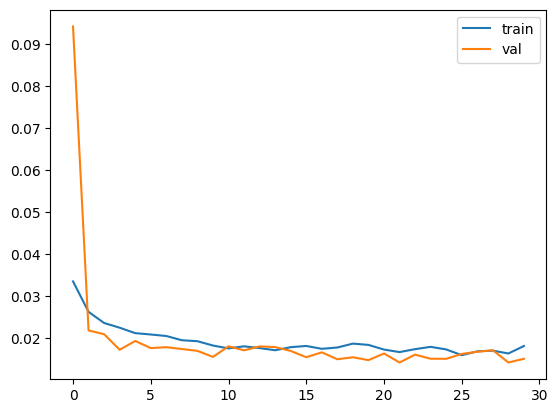

In [23]:
# Train model
model_reg, df = train_model(model_reg, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=30,verbose=0,plot_curves=True)

(0.01, 0.04)

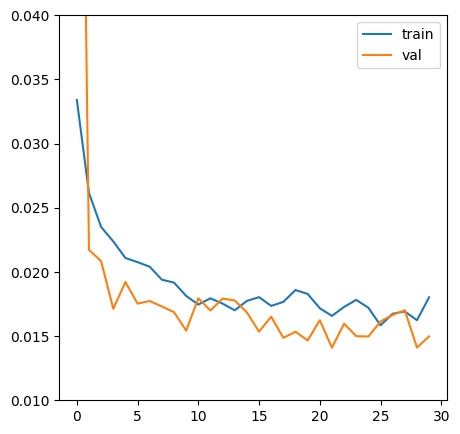

In [24]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
df.plot(ax=ax)
ax.set_ylim([0.01,0.04])

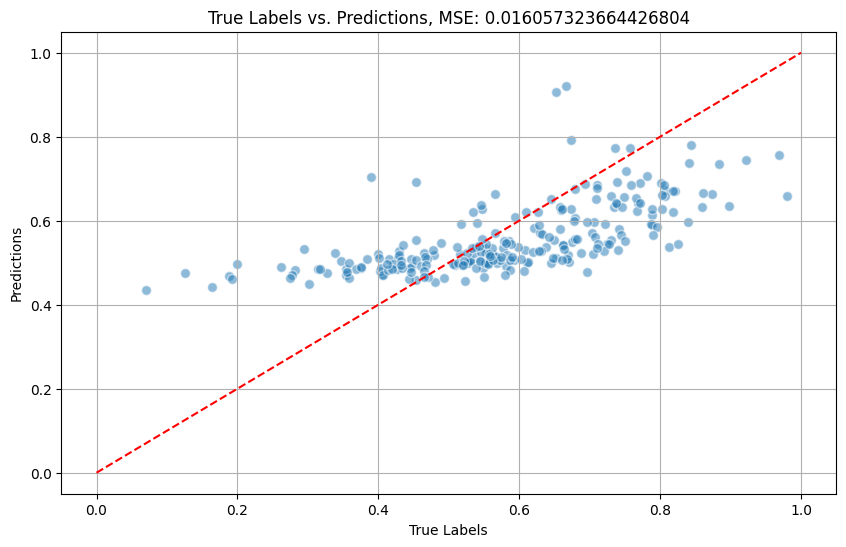

In [25]:
# Initialize lists to store the outputs and labels
all_outputs = []
all_labels = []

model_reg.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for image_inputs, tabular_inputs, labels in dataloaders['test']:
        image_inputs = image_inputs.to(device)
        tabular_inputs = tabular_inputs.to(device)
        labels = labels.to(device)
        outputs = model_reg(image_inputs, tabular_inputs)

        # Collect outputs and labels
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all collected outputs and labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([0,1], [0,1], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
# plt.xlim([0,1])
# plt.ylim([0,1]);

#### daysat trained on nightlight + xgboost

In [206]:
# Load data
data_path = 'data'
y = pd.read_csv(os.path.join(data_path,'y.csv'))\
    .rename(columns={'Wealth_Index':'target'})\
    .drop(columns=['DHSCLUST'])
y = y.astype({'target':'float32'})
X = pd.read_csv(os.path.join(data_path,'X.csv')).drop(columns=['DHSCLUST'])
# X = X.drop(columns=[col for col in X.columns if 'avg_rad' in col])
X.dropna(inplace=True)

In [207]:
# Perform train test split
ind_training, ind_test = train_test_split(X.index, test_size=0.2, random_state=42)
ind_train, ind_val = train_test_split(ind_training, test_size=0.2, random_state=42)

X_train = X.loc[ind_train,:]
X_val = X.loc[ind_val,:]
X_test = X.loc[ind_test,:]

y_train = y.loc[ind_train,:]
y_val = y.loc[ind_val,:]
y_test = y.loc[ind_test,:]

# MinMaxScale to target
scaler = MinMaxScaler()
scaler.fit(pd.concat([y_train,y_val],axis=0))
y_train = scaler.transform(y_train)
y_val = scaler.transform(y_val)
y_test = scaler.transform(y_test)

# Get image features
with open(os.path.join(data_path,'img_feat_dhs_2022_fc4.pkl'),'rb') as f:
    img_feat = pickle.load(f)

train_img_feat = img_feat[ind_train,:]
val_img_feat = img_feat[ind_val,:]
test_img_feat = img_feat[ind_test,:]

# Scale before PCA
scaler_img = StandardScaler()
scaler_img.fit(np.vstack([train_img_feat,val_img_feat]))
train_img_feat = scaler_img.transform(train_img_feat)
val_img_feat = scaler_img.transform(val_img_feat)
test_img_feat = scaler_img.transform(test_img_feat)

# Perform PCA
pca_img = PCA(n_components=50)
pca_img.fit(np.vstack([train_img_feat,val_img_feat]))
print(np.sum(pca_img.explained_variance_ratio_))
train_img_feat = pca_img.transform(train_img_feat)
val_img_feat = pca_img.transform(val_img_feat)
test_img_feat = pca_img.transform(test_img_feat)

# Get image features
X_train_img = pd.concat([X_train,
                     pd.DataFrame(train_img_feat,
                                  columns=[f'img_{i}' for i in range(train_img_feat.shape[1])],
                                  index=X_train.index)],
                    axis=1)
X_val_img = pd.concat([X_val,
                     pd.DataFrame(val_img_feat,
                                  columns=[f'img_{i}' for i in range(val_img_feat.shape[1])],
                                  index=X_val.index)],
                    axis=1)
X_test_img = pd.concat([X_test,
                     pd.DataFrame(test_img_feat,
                                  columns=[f'img_{i}' for i in range(test_img_feat.shape[1])],
                                  index=X_test.index)],
                    axis=1)

0.65435904


In [208]:
image_feature_names = [col for col in X_train_img.columns if 'img' in col]
HRSL_feature_names = ['pop_gen']
OOKLA_feature_names = ['fixed_2022_mean_avg_d_kbps_mean','fixed_2022_mean_avg_u_kbps_mean',
                       'fixed_2022_mean_avg_lat_ms_mean','fixed_2022_mean_num_tests_mean',
                       'fixed_2022_mean_num_devices_mean','mobile_2022_mean_avg_d_kbps_mean',
                       'mobile_2022_mean_avg_u_kbps_mean','mobile_2022_mean_avg_lat_ms_mean',
                       'mobile_2022_mean_num_tests_mean','mobile_2022_mean_num_devices_mean']
nightlight_feature_names = ['avg_rad_min','avg_rad_max','avg_rad_mean',
                            'avg_rad_std','avg_rad_median']
non_OSM_feature_names = image_feature_names+HRSL_feature_names+OOKLA_feature_names+nightlight_feature_names
non_OSM_n_img_feature_names = HRSL_feature_names+OOKLA_feature_names+nightlight_feature_names
OSM_feature_names = list(set(X_train.columns)-set(non_OSM_feature_names))

Testing performance
MSE: 0.0107


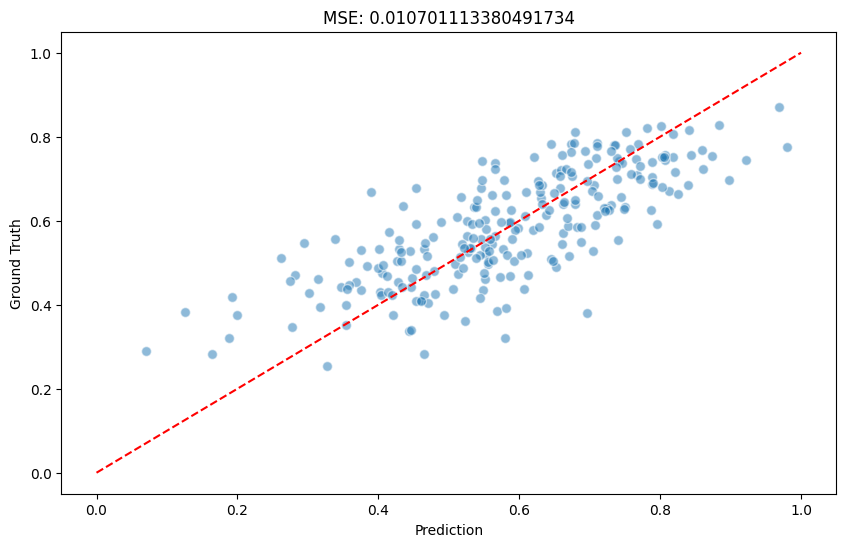

In [209]:
# After quick grid search below
params = {
    'learning_rate': 0.1,    'n_estimators': 100,    'max_depth': 6,    'min_child_weight': 1,    'gamma': 0,
    'subsample': 1,    'colsample_bytree': 0.8,    'reg_lambda': 1,    'reg_alpha': 0,    'objective': 'reg:squarederror',
    'random_state': 42,    'device':'cuda',    'tree_method':'hist',    # 'enable_categorical':True
}

feature_names = image_feature_names + OOKLA_feature_names + OSM_feature_names

model_xgb_base = xgb.XGBRegressor(**params)
model_xgb_base.fit(pd.concat([X_train_img,X_val_img],axis=0)[feature_names],np.vstack([y_train,y_val]))

model_xgb_base.set_params(device="cpu") # To prevent warning messages of model and array residing on different devices
pred = model_xgb_base.predict(X_test_img[feature_names])
mse = mean_squared_error(y_test,pred)
print('Testing performance')
print(f'MSE: {mse:.4f}')

fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.scatter(y_test, pred, alpha=0.5, edgecolors='w', s=50)
ax.plot([0,1], [0,1], color='red', linestyle='--', label='Ideal Line')
ax.set_title(f'MSE: {mse}')
ax.set_xlabel('Prediction')
ax.set_ylabel('Ground Truth');

# fig2, ax2 =plt.subplots(1,1,figsize=(5,5))
# xgb.plot_importance(model_xgb_base,max_num_features=20,ax=ax2)

In [210]:
all_feature_groups = {'OOKLA':OOKLA_feature_names,
                      'nightlight':nightlight_feature_names,
                      'image':image_feature_names,
                      'HRSL':HRSL_feature_names,
                      'OSM':OSM_feature_names}

# Generate all possible combinations of the items
combinations = []
for r in range(1, len(all_feature_groups) + 1):
    for combination in itertools.combinations(all_feature_groups.keys(), r):
        # Create a dictionary to represent the row
        row = {'OOKLA':0, 'nightlight':0, 'image':0, 'HRSL':0, 'OSM':0}
        combined_list = []
        
        for item in combination:
            row[item] = 1  # Mark the presence of this list
            combined_list.extend(all_feature_groups[item])  # Concatenate the lists
        
        # Add a label for the y-tick
        row['Label'] = ','.join(combination)
        
        row['feature_names'] = combined_list  # Store the combined list as well
        combinations.append(row)

df = pd.DataFrame(combinations)
df['MSE'] = 0

In [211]:
# After quick grid search below
params = {
    'learning_rate': 0.1,    'n_estimators': 100,    'max_depth': 6,    'min_child_weight': 1,    'gamma': 0,
    'subsample': 1,    'colsample_bytree': 0.8,    'reg_lambda': 1,    'reg_alpha': 0,    'objective': 'reg:squarederror',
    'random_state': 42,    'device':'cuda',    'tree_method':'hist',    # 'enable_categorical':True
}

for i, feature_names in enumerate(df['feature_names']):
    model_xgb_base = xgb.XGBRegressor(**params)
    # model_xgb_base.fit(X_trainval_img[feature_names], y_trainval)
    model_xgb_base.fit(pd.concat([X_train_img,X_val_img],axis=0)[feature_names], np.vstack([y_train,y_val]))
    
    model_xgb_base.set_params(device="cpu") # To prevent warning messages of model and array residing on different devices
    pred = model_xgb_base.predict(X_test_img[feature_names])
    
    mse = mean_squared_error(y_test,pred)
    df.loc[i,'MSE'] = mse

/tmp/ipykernel_119528/3699527369.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.011853043921291828' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i,'MSE'] = mse


In [212]:
df.drop(columns=['OOKLA','nightlight','image','HRSL','OSM','feature_names'])[df['image']==1].sort_values('MSE')

,Label,MSE
28,"OOKLA,image,HRSL,OSM",0.010053
19,"OOKLA,image,OSM",0.010718
30,"OOKLA,nightlight,image,HRSL,OSM",0.010770
13,"image,OSM",0.010832
26,"OOKLA,nightlight,image,OSM",0.010942
24,"image,HRSL,OSM",0.010969
22,"nightlight,image,OSM",0.010989
18,"OOKLA,image,HRSL",0.011063
29,"nightlight,image,HRSL,OSM",0.011136
6,"OOKLA,image",0.011259


In [213]:
df.drop(columns=['OOKLA','nightlight','image','HRSL','OSM','feature_names']).sort_values('MSE')

,Label,MSE
8,"OOKLA,OSM",0.009556
20,"OOKLA,HRSL,OSM",0.009692
28,"OOKLA,image,HRSL,OSM",0.010053
17,"OOKLA,nightlight,OSM",0.010502
19,"OOKLA,image,OSM",0.010718
27,"OOKLA,nightlight,HRSL,OSM",0.010765
30,"OOKLA,nightlight,image,HRSL,OSM",0.010770
14,"HRSL,OSM",0.010785
13,"image,OSM",0.010832
26,"OOKLA,nightlight,image,OSM",0.010942


In [215]:
df.head(1)

,OOKLA,nightlight,image,HRSL,OSM,Label,feature_names,MSE
0,1,0,0,0,0,OOKLA,"[fixed_2022_mean_avg_d_kbps_mean, fixed_2022_m...",0.011853


In [225]:
df.drop(columns=['OOKLA','nightlight','image','HRSL','OSM','feature_names'])[df['OSM']==1].drop(columns=['Label']).mean()

MSE    0.010719
dtype: float64

In [224]:
df.drop(columns=['OOKLA','nightlight','image','HRSL','OSM','feature_names'])[df['OOKLA']==1].drop(columns=['Label']).mean()

MSE    0.011038
dtype: float64

In [222]:
df.drop(columns=['OOKLA','nightlight','image','HRSL','OSM','feature_names'])[df['image']==1].drop(columns=['Label']).mean()

MSE    0.011604
dtype: float64

In [223]:
df.drop(columns=['OOKLA','nightlight','image','HRSL','OSM','feature_names'])[df['nightlight']==1].drop(columns=['Label']).mean()

MSE    0.011749
dtype: float64

In [226]:
df.drop(columns=['OOKLA','nightlight','image','HRSL','OSM','feature_names'])[df['HRSL']==1].drop(columns=['Label']).mean()

MSE    0.012577
dtype: float64

In [256]:
mean_squared_error(y_test,np.mean(np.hstack([y_train,y_val]))*np.ones(y_test.shape))

0.0263600652423372

0.56774104